In [1]:
import matplotlib
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from scipy.spatial import distance
from scipy import stats as ss
from numpy import random
from scipy import optimize
np.random.seed(seed=120)
import h5py

if 'cnode' not in os.uname()[1]:
    %matplotlib inline
    pass
else:
    matplotlib.use('Agg')

import matplotlib.ticker as ticker

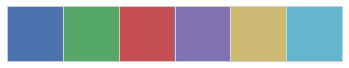

In [2]:
import seaborn as sns
from matplotlib import rc
sns.set(style='whitegrid', 
        rc={"grid.linewidth": 0.1,
            'grid.color': '.9'})
sns.set_context("paper")                                                  
color = sns.color_palette("Set2", 6)
rc('font',size=12)
rc('font',family='serif')
rc('axes',labelsize=12)
rc('text', usetex=True)

colors = ["light maroon", "faded purple", 
          "purplish", "faded green", 
          "dusty purple"]
test_palette = sns.xkcd_palette(colors)

current_palette = sns.color_palette()
sns.palplot(current_palette)
colorPal = {'blue': current_palette[0],
            'green': current_palette[1],
            'red': current_palette[2],
            'purple': test_palette[1], 
            'yellow': current_palette[4],
            'lightblue': current_palette[5]}

# Nice plotting stuff


# Definitions


In [5]:
def RMS(array):
    squared = np.multiply(array,array)
    summed = np.sum(squared)
    n = len(array)
    return np.sqrt((1.0/(n-1))*summed)


def errorOnMean(array):
    n = len(array)
    return RMS(array)/np.sqrt(n)


def replaceLine(file_name, parameter, newNumber):
        """
        Replacing some parameters in the 
        params.txt file to reflect the 
        lightcone being used
        """
        lines = open(file_name, 'r').readlines()
        print lines
        for i in range(len(lines)):
                words = content[i].split(" ")
                if words[0] == parameter:
                        lines[i] = \
                            parameter + " " + \
                            str(newNumber) + "\n"
        out = open(file_name, 'w')
        out.writelines(lines)
        out.close()

# Global parameters

In [6]:
with open("params.txt") as f:
    content = f.readlines()
    for i in range(len(content)):
        line = content[i].split("=")
        if line[0] == "NUMCUBES":
            numCubes = int(line[1])
        elif line[0] == "LIGHTCONE_PATH":
            path = line[1][:-1]
        elif line[0] == "OUTPUT_PATH":
            outPath = line[1][:-1]
        elif line[0] == "SOURCES":
            numSources = int(line[1])
        elif line[0] == "B0":
            B0 = float(line[1])
        elif line[0] == "ETA":
            eta = float(line[1])
        elif line[0] == "B_DIRECTION":
            B_Direction = \
                str(line[1]).split("\n")[0]
        elif line[0] == "RAYPIECES":
            raypieces = int(line[1])
outPath = outPath[:-1]
print os.uname()[1]
if 'cnode' not in str(os.uname()[1]):
    sysargv = '_1e-09_0.5_5000'
    outPath = '../../Thesis/Figures/'
    fileExtension = sysargv.replace('.', '')
    fileExtension += '_'
else:
    cmdargs = str(sys.argv)
    print cmdargs
    print sys.argv
    Bfield_extension = sys.argv[2]
    if len(sys.argv) > 1:
        outPathExtension = sys.argv[1] + '_' +\
                           Bfield_extension + '/'
    sysargv = sys.argv[1] + '_' + Bfield_extension
    fileExtension = sysargv.replace('.', '') + '_'
print fileExtension

Laurens-MacBook-Pro.local
_1e-09_05_5000_


In [7]:
def readInSources():
    print "Reading in sources..."
    with h5py.File('sourceData', 'r') as data:
        print data.keys()
        sourceRM = data['intrinsicRM'][:]
        sourcePos = data['sourcePositions'][:]
        sourceRadii = data['sourceRadii'][:]
        angularProjection = data[
            'sourceProjection'][:]
        sourceFlux = data['sourceFluxes'][:]
        if len(sourcePos)!= numSources:
            print "WARNING: Number of sources" \
                  " does not match parameter file"
    return sourceRM, angularProjection, \
        sourceRadii, sourcePos, sourceFlux

RM error is sampled from a normal distribution with mean=0 and sigma=$\sigma_B$.

 where $\sigma_B = \sigma_\epsilon\sqrt{\frac{1}{\frac{1}{N}\Sigma(\lambda_i^2 - \bar{\lambda}^2)^2}}$ 
 
 $\sigma_\epsilon = \dfrac{\sigma}{2P}$

 
 $\sigma(\nu) = \sigma_{770} \sqrt{\frac{770}{\Delta\nu}}$
 
 To calculate this, we have:
 - $\sigma_{770}$ = 2e-6 Jy
 - bandwidth $(\Delta\nu)$ = 770 Hz
 - $\sigma$ = 2e-6 (error on Q and U)
 - $\bar{\lambda}$ = 1300 Hz (central frequency)
 - $\lambda_i$ = 530-2070 Hz
 - n = 770 (chanel width = 1Hz)



In [8]:
def channelError(bandwidth, sigmaLevel):
    return sigmaLevel * np.sqrt(770.0 / bandwidth)


def freqToWavelength(freq):
    return 300.0/freq  
    # use 300 since frequencies are in Mhz


def assignError(length, flux, minFreq, maxFreq, 
                channels, sigmaLevel):
    minLambda = freqToWavelength(maxFreq)
    maxLambda = freqToWavelength(minFreq)
    print 'Wavelengths are', minLambda, 'to', \
        maxLambda
    centralLambda = freqToWavelength(
        (maxFreq + minFreq) / 2.0)
    bandwidthFreq = maxFreq - minFreq
    print 'Frequency bandwidth is', bandwidthFreq
    bandwidthLambda = maxLambda - minLambda
    channelWidthLambda = bandwidthLambda /\
                         channels
    sigma = channelError(bandwidthFreq,
                         sigmaLevel)
    # sigma = error on Q and U
    print 'sigma', sigma
    print 'Flux eg:', flux[:10]
    sigmaE = sigma / (2.0 * flux)   
    #flux = polarised flux density 
    xvals = np.linspace(minLambda / 2 + 
                        channelWidthLambda / 2,
                        maxLambda / 2 + 
                        channelWidthLambda / 2,
                        channels)
    deviation = xvals - np.mean(xvals)
    sigmaB = sigmaE * np.sqrt(1.0 / (
        (1.0 / channels) * sum(
            np.multiply(deviation, deviation))))
    errorVec = []
    np.random.seed(seed=100)
    for sb in range(len(sigmaB)):
        errorVec.append(
            random.normal(0.0, sigmaB[sb]))
    errorVec = np.array(errorVec).reshape(
        (len(sigmaB), 1))
    np.random.seed(seed=120)
    return errorVec


# 					Processing definitions


In [9]:
def readInData(numCubes, path):
    
    global numSources, raypieces
      
    RM = []
    galaxyRM = []
    haloRM = []
    hitPerSource = []
    signalRecieved = []
    
    sectionsExpected = numCubes*raypieces
    sectionsRecieved = 0.0
              
    for j in range(raypieces):
        RMlist = []   
        # list of RM vectors for the sources
        #  in this section
        galaxyRMlist = []
        haloRMlist = []
        signallist = []
        
        hitlist = 0
        hitTemp = 0
        for i in range(numCubes):
            sizeOfSourceSection = 100
            if j == raypieces-1:
                sizeOfSourceSection = \
                    numSources - 100 * j
            try:
                with h5py.File(os.path.expanduser(
                        path + 'particles_galaxies_'
                               'halos_hitPerSource_' +
                        str(i) + '_' + str(j)),
                        'r') as data:
                    try:
                        numberHit = data[str(i)][:]
                        if len(numberHit) == 0:
                            numberHit = np.zeros(
                                (sizeOfSourceSection,
                                 3), dtype=np.int)
                        if isinstance(hitTemp, int):
                            if numberHit.shape[1] == 3:
                                hitTemp = np.array(
                                    numberHit)
                        else:
                            if numberHit.shape[1] == 3:
                                hitTemp = np.add(
                                    hitTemp, numberHit) 
                    except KeyError:
                        if isinstance( hitTemp, int):
                            hitTemp = np.zeros(
                                (sizeOfSourceSection,
                                 3), dtype=np.int)
                        else:
                            hitTemp = np.zeros(
                                (sizeOfSourceSection, 
                                 3), dtype=np.int)
                if not isinstance(hitTemp, int):
                    if isinstance(hitlist, int):
                        hitlist = hitTemp
                    else:
                        hitlist = np.add(hitlist,
                                         hitTemp) 
                
                np.random.seed(seed=120)
                with h5py.File(os.path.expanduser(
                        path + 'rotationMeasure' + str(i) +
                        '_' + str(j)), 'r') as data:
                    for r in range(sizeOfSourceSection):  
                        # extract data per source
                        rm = data['rotationMeasure'][str(r)][:]
                        g = data['rotationMeasure_galaxy'][
                            str(r)][:]  
                        # this is a list of the indices of the
                        # useful galaxies
                        if len(g)  0:
                            grm = len(g) * random.normal(
                                0, 74.37, (len(g), 1))
                        else:
                            grm = 0
                        h = data['rotationMeasure_halo'][
                            str(r)][:]
                        if len(h)>0:
                            hrm = len(h) * random.normal(
                                0, 10, (len(h), 1))
                        else:
                            hrm = 0

                        if len(RMlist)<=r:
                            RMlist.append(rm)  
                            # RM vector for each source
                            signallist.append(np.count_nonzero(rm))  
                            # returns how many segments along the ray
                            #  will have non-zero counts
                            galaxyRMlist.append(grm)  
                            # Counts of galaxies hit - should match 
                            # number hit 
                            haloRMlist.append(hrm)
                        else:
                            RMlist[r] = np.append(RMlist[r], rm)
                            signallist[r] = np.append(
                                signallist[r], 
                                np.count_nonzero(rm))  
                            # returns how many segments along the ray 
                            # will have non-zero counts
                            galaxyRMlist[r] = np.append(
                                galaxyRMlist[r],
                                grm)  
                            # Counts of galaxies hit - should match 
                            # number hit 
                            haloRMlist[r] = np.append(haloRMlist[r], hrm)
                sectionsRecieved +=1
            except IOError:
                sectionFound = False
    
        RM += RMlist
        galaxyRM += galaxyRMlist
        haloRM += haloRMlist
        signalRecieved += signallist
        if isinstance( hitTemp, int ):
            hitlist = np.zeros(
                (sizeOfSourceSection, 6),
                dtype=np.int)
        if len(hitPerSource)==0:
            hitPerSource = hitlist
        else:
            hitPerSource = np.vstack(
                (hitPerSource, hitlist))

    print (sectionsRecieved/sectionsExpected)*100,\
        'percent of the files were present'
    # since the ray tracing algorithm adds a 
    # signal per halo, this line removes that 
    # signal and gives final number of halos
    
    print len(RM)
    totalRM = [np.sum(i) for i in RM]
    signalRecieved = [np.sum(i) for i 
        in signalRecieved]
    galaxyRM = [np.sum(i) for i in galaxyRM]
    haloRM = [np.sum(i) for i in haloRM]
    
    totalRM = np.array(totalRM)
    totalRM = np.reshape(totalRM, 
                         (len(totalRM), 1))
    signalRecieved = np.array(signalRecieved) 
    signalRecieved = np.reshape(
        signalRecieved,
        (len(signalRecieved), 1))
    
    galaxyRM = np.array(galaxyRM)
    galaxyRM = np.reshape(galaxyRM,
                          (len(galaxyRM), 1))
    haloRM = np.array(haloRM, dtype = np.int)
    haloRM = np.reshape(haloRM, (len(haloRM), 1))
    
    return totalRM, hitPerSource, signalRecieved, \
        galaxyRM, haloRM


In [10]:
def broadcastingRM(sourceAngle, RM, numSources):
    distDifference = distance.cdist(sourceAngle, sourceAngle,'cosine')  # difference in angular distances
    RMDifference = np.swapaxes(RM,0,1) - RM #similar to above, but for 1d data
    differenceTriangle = np.triu_indices(numSources,1) # take only below diagonal data - find indices
    ddn = distDifference[differenceTriangle]  #just all pairwise distances
#     ddn = ddn.reshape((len(ddn),1))
    rdj = RMDifference[differenceTriangle]  #just all pairwise distances
    rdn = np.multiply(rdj,rdj)  #RM differences squared
    rdj = rdj
    rdn = rdn
    return ddn,rdj,rdn


def broadcastOrder(RM,numSources,numOrders):
    global anglePos
#     print anglePos.shape,RM.shape,numSources
    differenceTriangle = np.triu_indices(numSources,1) # take only below diagonal data - find indices
    RMDifference = np.abs(np.swapaxes(RM,0,1) - RM) #similar to above, but for 1d data
    rdj = RMDifference[differenceTriangle]  #just all pairwise distannces
    rdn = rdj
    for n in range(numOrders):
        rdn = np.multiply(rdn,rdj)  #RM differences squares
    return rdn

In [11]:
def separatePosNeg(RM,sourceAngle):
    posInd = np.where( RM >= 0)[0]
    negInd = np.where( RM < 0 )[0]
#     e = sourceAngle[:,:2]
#     g = RM/np.max(np.abs(RM))
    pos = np.c_[sourceAngle[posInd], RM[posInd]]  #Translates slice objects to concatenation along the second axis.
    neg = np.c_[sourceAngle[negInd], RM[negInd]]
    return pos,neg


In [12]:
def powerLawFit(xdata,ydata,yerr):
    """
    Power-law fitting is best done by first converting
    to a linear equation and then fitting to a straight line.
    Note that the `logyerr` term here is ignoring a constant prefactor.

    fit powerlaw = lambda x, amp, index: amp * (x**index)

    y = a * x^b
    log(y) = log(a) + b*log(x)

    From http://scipy-cookbook.readthedocs.io/items/FittingData.html
    """
    
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    logyerr = yerr / ydata

    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
    
    pinit = [1.0, -1.0]
    out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)
    pfinal = out[0]
    covar = out[1]
    index = pfinal[1]
    amp = 10**pfinal[0]
    
    indexErr = np.sqrt( covar[1][1] )
    ampErr = np.sqrt( covar[0][0] ) * amp
    
    return [index,amp,indexErr,ampErr]

def binnedStats(ddn,rdn):
#     means= ss.binned_statistic(ddn, rdn, statistic='mean', bins=40)
    bin_means,bin_edges, binnumber = ss.binned_statistic(ddn, rdn, statistic='mean', bins=20)
    meanValues =  bin_means
    meanValues[np.isnan(meanValues)] = 0
    midpoints = bin_edges[:-1] + np.diff(bin_edges)/2
#     print midpoints,meanValues
    bin_rms , bin_edges2, binnumber2 = ss.binned_statistic(ddn, rdn, statistic=errorOnMean, bins=20)
    rms = bin_rms
    rmsAverage = []
    for i in rms:
        rmsAverage.append(np.mean(i))
    rmsAverage = np.array(rmsAverage)
    line = powerLawFit(binMidpoints,mean,rms)
    return midpoints,meanValues,rmsAverage,line

def binning(ddn,rdn):
    binNum = 30
    toBinx = np.array(ddn)
    toBiny= np.array(rdn)
    #20" limit (0,005 degrees)
    loc = np.where(toBinx>0.005)[0]
    toBinx = toBinx[loc]
    toBiny= toBiny[loc]
    #-----
    logToBin = np.log10(toBinx)
    binEdges = np.linspace(np.min(logToBin),np.max(logToBin),binNum+1)
    binEdges = 10**binEdges 
    binMidpoints = binEdges[:-1] + np.diff(binEdges)/2
    mean = [];rms = []
    for i in range(binNum):
        itemsInBin = toBiny[(toBinx>=binEdges[i])&(toBinx<binEdges[i+1])]
#         print len(itemsInBin)
        meanVal = np.mean(itemsInBin)
        mean.append(meanVal)
        rms.append(errorOnMean(itemsInBin))
    mean = np.array(mean)
    fit = powerLawFit(binMidpoints,mean,rms)
    return binMidpoints,mean,rms,fit  #binEdges



In [13]:
def SFCalculations(angles,RMs):
    distDifferenceNew,RMDifferenceJust,RMDifferenceNew = broadcastingRM(angles,RMs,len(RMs))
    midpoints,meanValues,rmsAverage,fitLine = binning(distDifferenceNew,RMDifferenceNew)
    return midpoints,meanValues,rmsAverage,fitLine


# Figure definitions

In [14]:
labels = {'SOURCEONLY':'Structure function from sources',
          'ALIGNED_1e-08_0.5_5000':'B field parallel to ray',
          'REALISTIC_1e-07_0.5_5000':'Realistic B field directions',
          'REALISTIC_1e-08_0.5_5000':'Realistic B field directions',
          'REALISTIC_1e-09_0.5_5000':'Realistic B field directions',
          'RANDOM_1e-08_0.5_5000':'Randomly aligned B field'}

colors = {'SOURCEONLY':'k',
          'ALIGNED_1e-08_0.5_5000':colorPal['yellow'], 
          'REALISTIC_1e-07_0.5_5000':colorPal['red'],
          'REALISTIC_1e-08_0.5_5000':colorPal['blue'],
          'REALISTIC_1e-09_0.5_5000':colorPal['green'],
          'RANDOM_1e-08_0.5_5000':colorPal['lightblue']}

In [15]:
def sourcePos(sourceAngle,rm):
    cmap = sns.diverging_palette(h_neg = 14, h_pos = 253, s=93, l=50, sep=1, n=6, center='light', as_cmap=True)
    fig = plt.figure(figsize=(6, 5), dpi=200)
    ax = plt.subplot(111)
    plt.scatter(sourceAngle[:,0],sourceAngle[:,1],edgecolors= 'none',c= rm,cmap=cmap)
    plt.xlabel('RA (degrees)')
    plt.ylabel('dec (degrees)')
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    cb = plt.colorbar(label = r'Intrinsic RM (rad\,m$^{-2}$)')
    plt.title('Source positions') 
    plt.savefig('sourcePositions.pdf',bbox_inches='tight')

In [16]:
def RMHist(tracingRM,sourceRM,direction):
    fig = plt.figure(figsize=(6, 3), dpi=200)
    ax = plt.subplot(121)
#     box = ax.get_position()
#     ax.set_position([box.x0*1.2, box.y0*1.1 + box.height * 0.1,box.width, box.width])
    # ax.set_xbound(lower=-0.6, upper=0.6)
    # ax.set_ylim(-0.6,0.6)
    plt.hist(tracingRM,bins=30)
    plt.xlabel('RM')
    plt.ylabel('Number')
    plt.title('Structure RM')
    
    start, end = ax.get_xlim()
    loc = ticker.MultipleLocator(base=end) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    
#     start, end = ax.get_xlim()
#     stepsize = start-end
#     print start,end
#     ax.xaxis.set_ticks(np.arange(start*1.1, 0.9*end,stepsize))
#     ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0e'))
    
    ax = plt.subplot(122)
    plt.hist(sourceRM,bins=30)
    plt.xlabel('RM')
    plt.ylabel('Number')
    plt.title('Source RM')
    plt.savefig(outPath+fileExtension+direction+'_compareRMHist.pdf',bbox_inches='tight')

In [17]:
def broadcastingFigures(ddn,rdj,rdn):
    fig = plt.figure(figsize=(6, 6), dpi=200)
    plt.subplots_adjust(hspace=0.7)
    plt.subplot(221)
    plt.hist(ddn)
    plt.title('Distance differences')
    plt.xlabel('Distance')
    plt.ylabel('Number')
    plt.subplot(222)
    plt.hist(rdj)
    plt.title('RM differences')
    plt.xlabel('RM')
    plt.ylabel('Number')
    plt.subplot(223)
    plt.hist(rdn)
    plt.title(r'RM$^2$')
    plt.xlabel(r'RM$^2$')
    plt.ylabel('Number')


In [18]:
def RMmap(p,n,constant,direction,RMType):  #positive,negative,constant,direction,type
    if direction == 'SOURCEONLY':
        fig = plt.figure(figsize=(6, 5), dpi=200)        
    else:
        fig = plt.figure(figsize=(5, 5), dpi=200)
    ax = plt.subplot(111)
    try:
        ax.scatter(p[:,0],p[:,1],s =constant*abs(p[:,2]),c = "royalblue",alpha = 0.5,edgecolors='none')#,label = "Positive RM")
    except:
        pass
    try:
        ax.scatter(n[:,0],n[:,1],s = constant*abs(n[:,2]),c = 'indianred',alpha = 0.5,edgecolors='none')#,label = 'Negative RM')
    except:
        pass
    plt.xlabel("RA (degrees)")
    plt.ylabel("dec (degrees)")
    box = ax.get_position()
    ax.set_position([box.x0*1.2, box.y0*1.07+ box.height * 0.1,box.width, box.width])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    
    gll = plt.scatter([],[], s = constant*0.5, marker='o', color='#555555')
    gl = plt.scatter([],[], s = constant*5, marker='o', color='#555555')
    ga = plt.scatter([],[], s = constant*50, marker='o', color='#555555')

    #legend1 = 
    plt.legend((gll,gl,ga),
       (r'0.5 rad/m$^2$', r'5 rad/m$^2$', r'50 rad/m$^2$'),
       scatterpoints=1,
       bbox_to_anchor=(0.1, 1),#(0.075, 0.91), 
       loc=3,
#        frameon=True,
       ncol=3,
#        title=r'Normalised Rotation Measure (rad/m$^2$)',                 
       fontsize=8)
    
#     ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.11),fancybox=True, shadow=True, ncol=5)
#     leg = plt.gca().add_artist(legend1)
#     frame = leg.get_frame()
#     frame.set_facecolor('white')
    plt.tight_layout()
    
    plt.savefig(outPath+fileExtension+direction+'_RMmap_'+RMType+'.pdf',bbox_inches='tight')

In [19]:
def scatterRMDist(distDifference,RMDifference,direction):
    plt.figure()
    fig = plt.subplot(111)
    plt.scatter(distDifference,np.log(RMDifference))
    plt.ylabel(r" S (rad$^2$/m$^{-4}$)")
    plt.xlabel(r"log $\Delta\theta$ (degrees)")
    plt.savefig(outPath+fileExtension+direction+'_RMvsDist.pdf',bbox_inches='tight')

In [20]:
def BRF(ylimits,mp,mv,ra,ln,direction,RMType,cList,scaled=False):
    fig = plt.figure(figsize=(6,3), dpi=200)
    ax = fig.add_subplot(111)
    
    if RMType == '':
        try:
            print 'means', np.mean(mv)
            ax.errorbar(mp,mv,yerr=ra,c=cList[0],fmt='o')
        except:
            print 'means',[np.mean(x) for x in mv]
#         ax.errorbar(mp,mv,yerr=ra,fmt='o',label ="Slope of structure function = {0:.2f}".format(ln[0]))
    else:
        print 'means',[np.mean(x) for x in mv]
        if isinstance(RMType,list):
            for n in range(len(mp)):
                plt.errorbar(mp[n],mv[n],yerr=ra[n],c = cList[n],fmt='o:',label = RMType[n])

        else:
            ax.errorbar(mp[0],mv[0],yerr=ra[0],fmt='o:',c = cList[0],label = 'Source SF only')
            ax.errorbar(mp[1],mv[1],yerr=ra[1],fmt='o:',c = cList[1],label = 'Source SF with '+RMType+' signal only')
            ax.errorbar(mp[2],mv[2],yerr=ra[2],fmt='o:',c = cList[2],label = 'Source SF with '+RMType+' signal and LSS')
    if scaled:
        plt.ylabel(r" S (rad$^2$/m$^{-4}$)+c")
    else:
        plt.ylabel(r" S (rad$^2$/m$^{-4}$)")
    plt.xlabel(r"log $\Delta\theta$ (degrees)")
    plt.xscale('log')
    plt.yscale('log')
    if direction == 'SOURCEONLY':
        ax.errorbar(mp[0],mv[0],yerr=ra[0],c = cList[0],fmt='o:',label =r"Slope without observational error= {0:.2f}".format(ln[1][0]))
        ax.errorbar(mp[1],mv[1],yerr=ra[1],c = cList[1],fmt='o:',label ="Slope with observational error= {0:.2f}".format(ln[0][0]))
        expect = np.full_like(mv[1],72.0)
        ax.plot(mp[1],expect,':',c = cList[2],label = 'Expectation value',linewidth=3.0)
#         ax.fill_between(mp[0], mv[0]-ra[0],mv[0]+ra[0],alpha = 0.1,linewidth=0.0)
#         ax.fill_between(mp[1], mv[1]-ra[1],mv[1]+ra[1],alpha = 0.1,linewidth=0.0)
    plt.ylim(ylimits[0],ylimits[1])
    plt.locator_params(axis='x', numticks=6)

    plt.locator_params(axis='y', numticks=3)
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%d"))
    
    
def binnedRMFigure(ylimits,mp,mv,ra,ln,direction,RMType,cList,scaled = False):
    try:
        mp2 = [x[:-1] for x in mp]
        mv2 = [x[:-1] for x in mv]
        ra2 = [x[:-1] for x in ra]
    except:
        mp2 = mp[:-1]
        mv2 = mv[:-1]
        ra2 = ra[:-1]  
    BRF(ylimits,mp2,mv2,ra2,ln,direction,RMType,cList,scaled)
#     plt.xlim(0,1.8)
    #     plt.yscale('log');plt.xscale('log')
    if direction == 'SOURCEONLY':
        plt.savefig(outPath+'sourceExpect.pdf', bbox_inches='tight')
    elif direction == 'None':
        pass
    elif direction != 'SOURCEONLY':
        if isinstance(RMType,list):
            plt.savefig(outPath+fileExtension+direction+'_binnedRMDist_'+'comparePlots_'+direction+'.pdf',bbox_inches='tight')           
        else:
            plt.savefig(outPath+fileExtension+direction+'_binnedRMDist_'+RMType+'.pdf',bbox_inches='tight')
    else:
        plt.savefig(outPath+fileExtension+'SOURCEONLY_binnedRMDist.pdf',bbox_inches='tight')

In [21]:
def binnedRMFigureExtended(ylimits,mp,mv,ra,ln,direction,RMType,cList,scaled = False):
    BRF(ylimits,mp,mv,ra,ln,direction,RMType,cList,scaled)
#     plt.yscale('log');plt.xscale('log')
    if direction == 'None':
        pass
    elif direction != 'SOURCEONLY':
        if isinstance(RMType,list):
            plt.savefig(outPath+fileExtension+direction+'_binnedRMDist_'+'comparePlots_'+direction+'.pdf',bbox_inches='tight')           
        else:
            plt.savefig(outPath+fileExtension+direction+'_binnedRMDist_'+RMType+'.pdf',bbox_inches='tight')
    else:
        plt.savefig(outPath+fileExtension+'SOURCEONLY_binnedRMDistExtended.pdf',bbox_inches='tight')

In [22]:
def to_percent(y, position):
        # Ignore the passed in position. This has the effect of scaling the default
        # tick locations.
        s = str(100 * y/2675.0)[:4]

        # The percent symbol needs escaping in latex
        if matplotlib.rcParams['text.usetex'] is True:
            return s + r'$\%$'
        else:
            return s + '%'

def numberHitFigure(hitPerSource,direction):
    fig,(ax1, ax2,ax3) = plt.subplots(1,3,sharey=True, figsize = (6,3))
    print 'Most particles hit:',np.max(hitPerSource[:,0])
    print 'Most galaxies hit:',np.max(hitPerSource[:,1])
    print 'Most halos hit:',np.max(hitPerSource[:,2])


    # Make a normed histogram. It'll be multiplied by 100 later.
    h1= ax1.hist(hitPerSource[:,0], label='particle',bins=15,color = colorPal['blue'],alpha=0.6)
    h2 = ax2.hist(hitPerSource[:,1], label='galaxy',bins=15,color = colorPal['green'],alpha=0.6)
    h2 = ax3.hist(hitPerSource[:,2], label='halo',bins=15,color = colorPal['red'],alpha=0.6)
    ax1.set_yticks([0,2675/4.0,2675/2.0,3*2675/4.0])
    # Create the formatter using the function to_percent. This multiplies all the
    # default labels by 100, making them all percentages
    formatter = FuncFormatter(to_percent)
    # Set the formatter
    plt.gca().yaxis.set_major_formatter(formatter)
#     ax1.yaxis.set_major_formatter(formatter)
#     ax2.yaxis.set_major_formatter(formatter)
#     ax3.yaxis.set_major_formatter(formatter)


#     ax1.set_xlim(0,85000)
#     start, end = ax1.get_xlim()
#     stepsize = start-end/5.0
#     print start,end
#     ax1.xaxis.set_ticks(np.arange(start, end+1, 20000))
#     ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0e'))
    
#     red_patch = mpatches.Patch(color='red',alpha=0.6)
#     green_patch = mpatches.Patch(color='green',alpha=0.6)
#     blue_patch = mpatches.Patch(color='blue',alpha=0.6)
#     proxy_lines = [blue_patch,green_patch,red_patch]
#     leg = plt.figlegend(proxy_lines,['Gas','Galaxies','Halos'],loc='upper center', bbox_to_anchor=(0.5, 1.15),
#           ncol=3, fancybox=True, shadow=True)
    plt.tight_layout()
    fig.text(0.5, -0.05, 'Number of objects hit', ha='center')
    fig.text(-0.01, 0.5, 'Fraction of rays', va='center', rotation='vertical')
    plt.savefig(outPath+fileExtension+direction+'_allHit.pdf',bbox_inches='tight')

In [23]:
# numberHitFigure(hitPerSource['REALISTIC_1e-08_0.5_5000'],'REALISTIC')

In [24]:
def CBRM(ylimits,midpoints,meanValues,rmsAverage,*args):
    fig = plt.figure(figsize=(6,3), dpi=200)
    ax = fig.add_subplot(111)
    if args[0] == 'directions':
        for d in ['SOURCEONLY','REALISTIC_1e-08_0.5_5000','RANDOM_1e-08_0.5_5000','ALIGNED_1e-08_0.5_5000']:
            mid = midpoints[d]
            mean = meanValues[d]
            rms = rmsAverage[d]
            print 'mean', d, np.mean(mean)
            if d == "SOURCEONLY":
                pass
#                 ax.plot(mid,mean,'o:', label = labels[d],c = "black")
#                 ax.fill_between(mid, mean-rms,mean+rms,facecolor='black',alpha = 0.1,linewidth=0.0)
            elif d.split('_')[1] == '1e-08' :
                ax.errorbar(mid,mean,yerr=rms, c = colors[d],fmt='o:', label = labels[d])
    elif args[0] =='strengths':
        for d in ['SOURCEONLY','REALISTIC_1e-08_0.5_5000','REALISTIC_1e-07_0.5_5000','REALISTIC_1e-09_0.5_5000']:
            mid = midpoints[d]
            mean = meanValues[d]
            rms = rmsAverage[d]
            print 'mean', d, np.mean(mean)
            if d == "SOURCEONLY":
                pass
#                 ax.plot(mid,mean,'o:', label = labels[d],c = "black")
#                 ax.fill_between(mid, mean-rms,mean+rms,facecolor='black',alpha = 0.1,linewidth=0.0)
            elif d.split('_')[0] == 'REALISTIC' :
                ax.errorbar(mid,mean,yerr=rms,c = colors[d],fmt='o:', label = labels[d])
    else:     
        for d in args:
            mid = midpoints[d]
            mean = meanValues[d]
            rms = rmsAverage[d]
            print 'mean', d, np.mean(mean)
#             if d == "SOURCEONLY":
#                 ax.plot(mid,mean,'o:', label = labels[d],c = "black")
#                 ax.fill_between(mid, mean-rms,mean+rms,facecolor='black',alpha = 0.1,linewidth=0.0)
#             else:
            ax.errorbar(mid,mean,yerr=rms,c = colors[d],fmt='o:', label = labels[d])
#     ax.legend(bbox_to_anchor=(1,0.7), loc=2, ncol=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r" S (rad$^2$/m$^{-4}$)")
    plt.xlabel(r"log $\Delta\theta$ (degrees)")
    plt.ylim(ylimits[0],ylimits[1])
    if ylimits[0] == 4300:
        if ylimits[1] == 4800:
            ax.set_yticks([4400, 4500, 4600, 4700])
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    elif ylimits[0] == 89:
        if ylimits[1] == 170:
            ax.set_yticks([100,130, 160])
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
            ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
    else:
        plt.locator_params(axis='x', numticks=6)
        plt.locator_params(axis='y', numticks=4)
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  
    
    
def compareBinnedRM(ylimits,mp,mv,ra,LSS_vs_observed,*args):
    mp2 = {};mv2={};ra2={}
    for i in mp.keys():
        mp2[i] = mp[i][:-1]
        mv2[i] = mv[i][:-1]
        ra2[i] = ra[i][:-1]

    CBRM(ylimits,mp2,mv2,ra2,*args)


    if args[0] =='directions':
        plt.savefig(outPath+fileExtension+str(args[0])+'binnedRMDist_comparison_'+LSS_vs_observed+'.pdf',bbox_inches='tight')
    elif args[0] =='strengths':
        plt.savefig(outPath+fileExtension+str(args[0])+'binnedRMDist_comparison_'+LSS_vs_observed+'.pdf',bbox_inches='tight')
    else:
        plt.savefig(outPath+fileExtension+str(args[-1][:-15])+'binnedRMDist_comparison_'+LSS_vs_observed+'.pdf',bbox_inches='tight')


In [25]:
def compareBinnedRM_plusonepoint(ylimits,mp,mv,ra,LSS_vs_observed,*args):
    CBRM(ylimits,mp,mv,ra,*args)
    
    if args[0] =='directions':
        plt.savefig(outPath+fileExtension+str(args[0])+'binnedRMDist_comparison__'+LSS_vs_observed+'_extended.pdf',bbox_inches='tight')
    elif args[0] =='strengths':
        plt.savefig(outPath+fileExtension+str(args[0])+'binnedRMDist_comparison__'+LSS_vs_observed+'_extended.pdf',bbox_inches='tight')
    else:
        plt.savefig(outPath+fileExtension+str(args[-1][:-15])+'binnedRMDist_comparison__'+LSS_vs_observed+'_extended.pdf',bbox_inches='tight')


In [26]:
def prepareAndPlotJustStructure(ylimits,sourceAngle,SFcontribution,numSources,direction):
    misS,meanS,rmsS,lineS = SFCalculations(sourceAngle,SFcontribution)
    binnedRMFigure(ylimits,misS,meanS,rmsS,lineS,'None','',[colorPal['purple']])
#     binnedRMFigureExtended(ylimits,misS,meanS,rmsS,lineS,'None','',[colorPal['purple']])
    plt.savefig(outPath+fileExtension+'simplyStructure.pdf',bbox_inches='tight')

In [27]:
def addGalaxyHalo(RMvals,direction,label,ylimits,cList):
    global sourceRM,totalRM,anglePos,numSources,midpoints,meanValues,rmsAverage,fitLine
    mid = [];mean = [];rms=[];line=[]
    for i in range(3):
        posN,negN = separatePosNeg(RMvals[i],anglePos)
        midN,meanN,rmsN,lineN =  SFCalculations(anglePos,RMvals[i])
        if i == 3:
            RMmap(posN,negN,200,direction,label)
        mid.append(midN)
        mean.append(meanN)
        rms.append(rmsN)
        line.append(lineN)
    RMmap(posN,negN,2,direction,label)
    binnedRMFigure(ylimits,mid,mean,rms,line,direction,label,cList)
#     binnedRMFigureExtended(ylimits,mid,mean,rms,line,direction,label)
    return [x[0] for x in line]

In [28]:
def compareOrders(numOrders,RM,ddn,rdn):
    global numSources
    slope = []
    for i in range(1,numOrders):
        order = broadcastOrder(RM,numSources,i)
        md,mv,rms,line = binning(ddn,order)
        slope.append(line[0])
    plt.figure(figsize = (6,3))
    plt.plot(range(1,numOrders),slope)

In [29]:
def compareRMs(RMList,scaleList,labelList,ylimits,description,cList):
    global anglePos,numSources
    mid = [];mean = [];rms=[];line=[]
    for i in range(len(RMList)):
        mid_temp,mean_temp,rms_temp,line_temp = SFCalculations(anglePos,RMList[i]*scaleList[i])
        mid.append(mid_temp)
        mean.append(mean_temp)
        rms.append(rms_temp)
        line.append(line_temp)
    binnedRMFigure(ylimits,mid,mean,rms,line,description,labelList,cList,True)
#     binnedRMFigureExtended(ylimits,mid,mean,rms,line,description,labelList)
    return line

In [30]:
def processParameter(strength,BfieldDirection): 
    global overallRM,hitPerSource,galaxyRM,structureFound,totalRM,observedRM,pos,neg
    global distDifferenceNew,RMDifferenceJust,RMDifferenceNew
    global midpoints,meanValues,rmsAverage,fitLine
    global distDifferenceNew_obs,RMDifferenceJust_obs,RMDifferenceNew_obs
    global midpoints_obs,meanValues_obs,rmsAverage_obs,fitLine_obs
    global sysargv,direction,outPath,fileExtension,fileExtension
    
    sysargv = '_'+strength+'_0.5_5000'
    direction = BfieldDirection+sysargv
    outPath = '../../Thesis/Figures/'
    fileExtension = sysargv.replace('.','')
    fileExtension += '_'
    path = 'output'+BfieldDirection+sysargv+'/'
    
    print path,direction
    overallRM[direction],hitPerSource[direction],structureFound[direction],galaxyRM[direction],haloRM[direction] = readInData(numCubes,path)
    totalRM[direction] = np.add(overallRM[direction],sourceRM) #np.add(totalRM,sourceRM)
    observedRM[direction] = totalRM[direction] + galaxyRM[direction]
    
    midpoints[direction],meanValues[direction],rmsAverage[direction],fitLine[direction] = SFCalculations(anglePos,totalRM[direction])
    midpoints_obs[direction],meanValues_obs[direction],rmsAverage_obs[direction],fitLine_obs[direction] = SFCalculations(anglePos,observedRM[direction])
   
    if direction == 'REALISTIC_1e-08_0.5_5000':
        print 'Number of particles where 0 are hit:',len(hitPerSource[direction][:,0][hitPerSource[direction][:,0]==0])
        print 'Number of particles where 0<x<10 are hit:',len(hitPerSource[direction][:,0][(0<hitPerSource[direction][:,0])&(hitPerSource[direction][:,0]<10)])
        print 'Number of galaxies where 0 are hit:',len(hitPerSource[direction][:,1][hitPerSource[direction][:,1]==0])
        print 'Number of galaxies where 0<x<10 are hit:',len(hitPerSource[direction][:,1][(0<hitPerSource[direction][:,1])&(hitPerSource[direction][:,1]<20)])
        print 'Number of halos where 0 are hit:',len(hitPerSource[direction][:,2][hitPerSource[direction][:,2]==0])
        print 'Number of halos where 0<x<10 are hit:',len(hitPerSource[direction][:,2][(0<hitPerSource[direction][:,2])&(hitPerSource[direction][:,2]<20)])

        RMHist(overallRM[direction],sourceRM,BfieldDirection)
        
        distDifferenceNew[direction],RMDifferenceJust[direction],RMDifferenceNew[direction] = broadcastingRM(anglePos,totalRM[direction],numSources)
        broadcastingFigures(distDifferenceNew[direction],RMDifferenceJust[direction],RMDifferenceNew[direction])
        
        pos,neg = separatePosNeg(totalRM[direction],anglePos)
        RMmap(pos,neg,2,BfieldDirection,'')
        pos_obs,neg_obs = separatePosNeg(observedRM[direction],anglePos)
        RMmap(pos_obs,neg_obs,2,BfieldDirection,'observed')
        
        numberHitFigure(hitPerSource[direction],BfieldDirection)
        prepareAndPlotJustStructure((7.5e4,8.5e4),anglePos,structureFound[direction],numSources,BfieldDirection)
        
        print meanValues[direction]
        print meanValues_obs[direction]
        
        binnedRMFigure((120,135),midpoints[direction],meanValues[direction],rmsAverage[direction],fitLine[direction],BfieldDirection,'',[colors[direction]])
#         binnedRMFigureExtended((85,6000),midpoints[direction],meanValues[direction],rmsAverage[direction],fitLine[direction],BfieldDirection,'')

        compareBinnedRM((85,135),midpoints,meanValues,rmsAverage,'LSSonly','SOURCEONLY',direction)
#         compareBinnedRM_plusonepoint((85,135),midpoints,meanValues,rmsAverage,'LSSonly','SOURCEONLY',direction)

        compareBinnedRM((80,5200),midpoints_obs,meanValues_obs,rmsAverage_obs,'observed','SOURCEONLY',direction)
#         compareBinnedRM_plusonepoint((85,6000),midpoints_obs,meanValues_obs,rmsAverage_obs,'observed','SOURCEONLY',direction)
        
        compareRMs([totalRM[direction],observedRM[direction]],[1,1],['',''],[100,5000],'compareLSSGalaxy',[colors[direction],colorPal['purple']])
        compareRMs([sourceRM,totalRM[direction],observedRM[direction]],[1,1,1],['','',''],[80,5000],'compareSourceLSSGalaxy',[colors['SOURCEONLY'],colors[direction],colorPal['purple']])
    
    

# Ray independent

In [31]:
overallRM = {}
hitPerSource = {}
galaxyRM = {}
haloRM = {}
structureFound = {}
totalRM = {}
observedRM = {}
distDifferenceNew = {}
RMDifferenceJust = {}
RMDifferenceNew = {}
midpoints = {}
meanValues = {}
rmsAverage = {}
fitLine = {}
distDifferenceNew_obs = {}
RMDifferenceJust_obs = {}
RMDifferenceNew_obs = {}
midpoints_obs = {}
meanValues_obs = {}
rmsAverage_obs = {}
fitLine_obs = {}

Reading in sources...
[u'intrinsicRM', u'sourceFluxes', u'sourcePositions', u'sourceProjection', u'sourceRadii', u'sourceRedshifts']
Wavelengths are 0.1875 to 0.333333333333
Frequency bandwidth is 700
0.1875 0.333333333333 0.24 0.000208333333333
sigma 1.04880884817e-07
Flux eg: [  2.62928096e-04   2.28381570e-03   1.75826578e-05   2.49131069e-05
   2.27194005e-04   2.91469798e-04   2.98146753e-05   3.18671734e-04
   7.99262299e-05   3.91418363e-05]
Wavelengths are 0.1875 to 0.333333333333
Frequency bandwidth is 700
0.1875 0.333333333333 0.24 0.000208333333333
sigma 2.09761769634e-06
Flux eg: [  2.62928096e-04   2.28381570e-03   1.75826578e-05   2.49131069e-05
   2.27194005e-04   2.91469798e-04   2.98146753e-05   3.18671734e-04
   7.99262299e-05   3.91418363e-05]
maximum flux,error 0.00752255178446 [ 12.8821176] 3.0305038264
maximum flux,error 0.00752255178446 [ 0.64410588] 0.15152519132
means 81.3307823063
means [72.069196769304057, 90.592367843224451]
means 81.3256548245
means [72.068

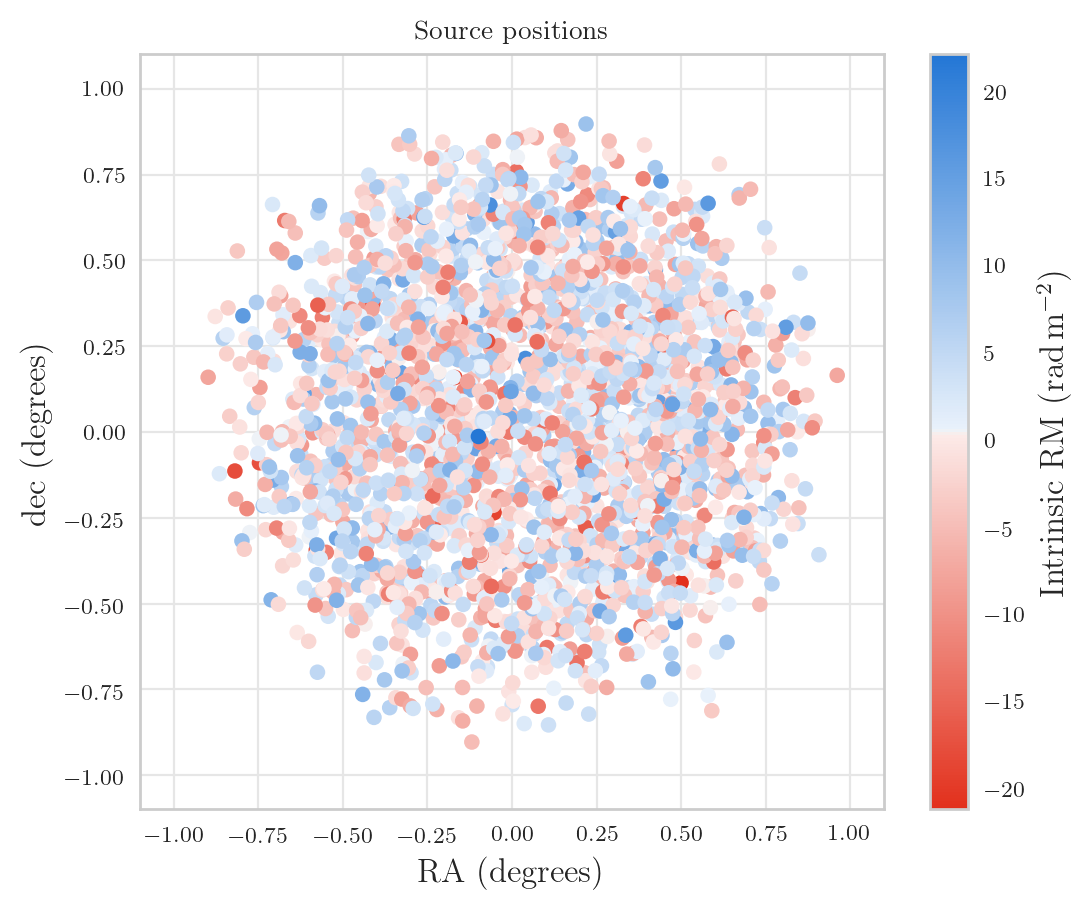

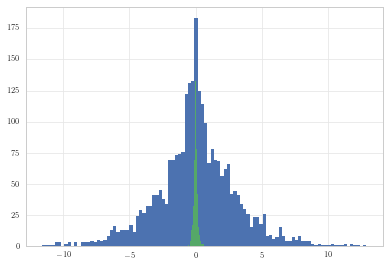

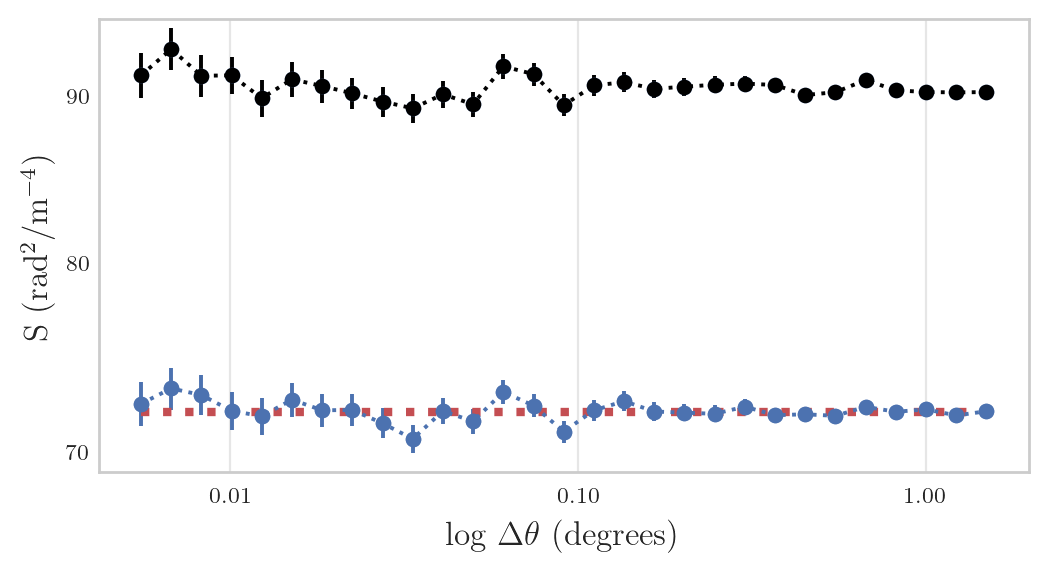

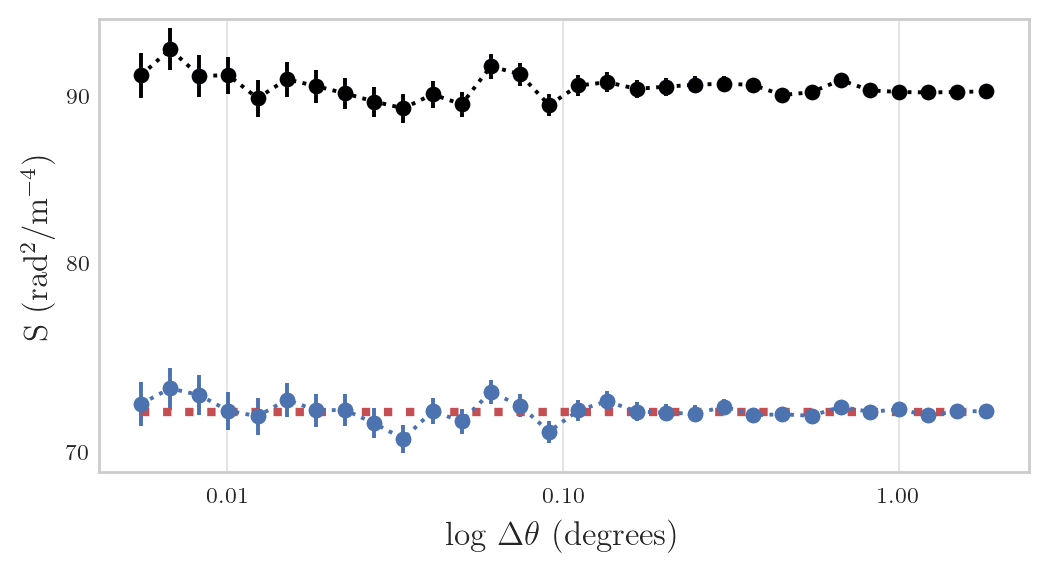

In [32]:
# np.random.seed(seed=1)
sourceRM_old,anglePos, radii, sourcePositions, sourceFlux = readInSources()
np.random.seed(seed=120)
sourceRM_beforeError = random.normal(0, 6, size=(len(radii),1))
sourcePos(anglePos,sourceRM_beforeError)

RMerror_0p1 = assignError(len(sourceRM_beforeError),sourceFlux,900,1600,700,0.1e-6)
RMerror_2p0 = assignError(len(sourceRM_beforeError),sourceFlux,900,1600,700,2.0e-6)

plt.figure()
plt.hist(RMerror_2p0,bins = 100)
print 'maximum flux,error',max(sourceFlux),max(RMerror_2p0),np.std(RMerror_2p0)
plt.hist(RMerror_0p1,bins = 100)
print 'maximum flux,error',max(sourceFlux),max(RMerror_0p1),np.std(RMerror_0p1)

np.savetxt('RMerror_2p0.txt',RMerror_2p0)
np.savetxt('RMerror_0p1.txt',RMerror_0p1)

np.savetxt('sourceRM.txt',sourceRM_beforeError)
mi,me,rAv,fL = SFCalculations(anglePos,sourceRM_beforeError)


sourceRM = sourceRM_beforeError + RMerror_2p0

direction = 'SOURCEONLY'
SFCalculations(anglePos,sourceRM)

midpoints[direction],meanValues[direction],rmsAverage[direction],fitLine[direction] = SFCalculations(anglePos,sourceRM)
midpoints_obs[direction],meanValues_obs[direction],rmsAverage_obs[direction],fitLine_obs[direction] = midpoints[direction],meanValues[direction],rmsAverage[direction],fitLine[direction]

binnedRMFigure((69,95),[mi,midpoints[direction]],[me,meanValues[direction]],[rAv, rmsAverage[direction]],[fL,fitLine[direction]],direction,'',[colorPal['blue'],colors[direction],colorPal['red']])
binnedRMFigureExtended((69,95),[mi,midpoints[direction]],[me,meanValues[direction]],[rAv,rmsAverage[direction]],[fL, fitLine[direction]],direction,'',[colorPal['blue'],colors[direction],colorPal['red']])
print fitLine[direction],fitLine_obs[direction]


print RMerror_2p0
print meanValues['SOURCEONLY'] - np.mean(meanValues['SOURCEONLY'])
print rmsAverage['SOURCEONLY']
print (meanValues['SOURCEONLY'] - np.mean(meanValues['SOURCEONLY']))/rmsAverage['SOURCEONLY']

# Process rays

In [33]:
processParameter('1e-07','REALISTIC')

outputREALISTIC_1e-07_0.5_5000/ REALISTIC_1e-07_0.5_5000
100.0 percent of the files were present
2675


In [34]:
processParameter('1e-09','REALISTIC')

outputREALISTIC_1e-09_0.5_5000/ REALISTIC_1e-09_0.5_5000
100.0 percent of the files were present
2675


outputREALISTIC_1e-08_0.5_5000/ REALISTIC_1e-08_0.5_5000
100.0 percent of the files were present
2675
Number of particles where 0 are hit: 0
Number of particles where 0<x<10 are hit: 0
Number of galaxies where 0 are hit: 2246
Number of galaxies where 0<x<10 are hit: 0
Number of halos where 0 are hit: 960
Number of halos where 0<x<10 are hit: 0
Most particles hit: 1272273
Most galaxies hit: 84
Most halos hit: 171
means 79275.6418835
[ 126.87809472  125.778074    124.07500734  121.1459628   124.60855606
  125.12779335  125.79818555  124.96548634  124.38385783  126.3022975
  123.99614295  125.38024999  126.4323577   126.20220958  123.52669664
  124.27533505  125.85735958  124.4282466   124.69420755  125.44589661
  126.10235082  126.29590018  124.8350557   123.80302621  125.37533305
  125.93268737  124.61257978  125.88970471  125.38372037  125.77604338]
[ 4523.12362052  4462.91978288  4447.73128269  4537.80382515  4588.83447774
  4706.64100562  4648.23995009  4637.39800526  4629.3740054   

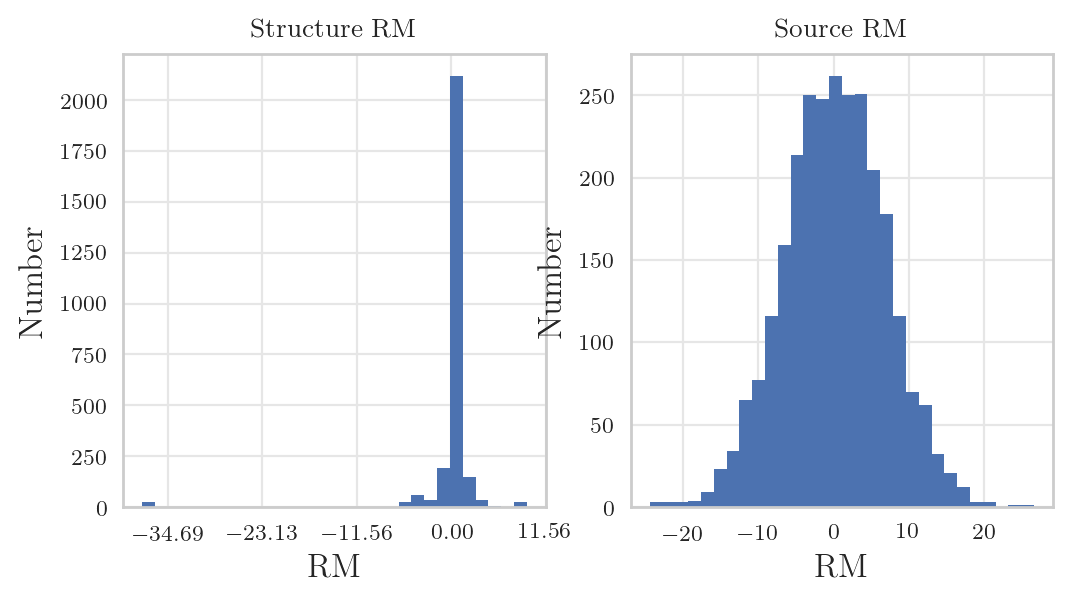

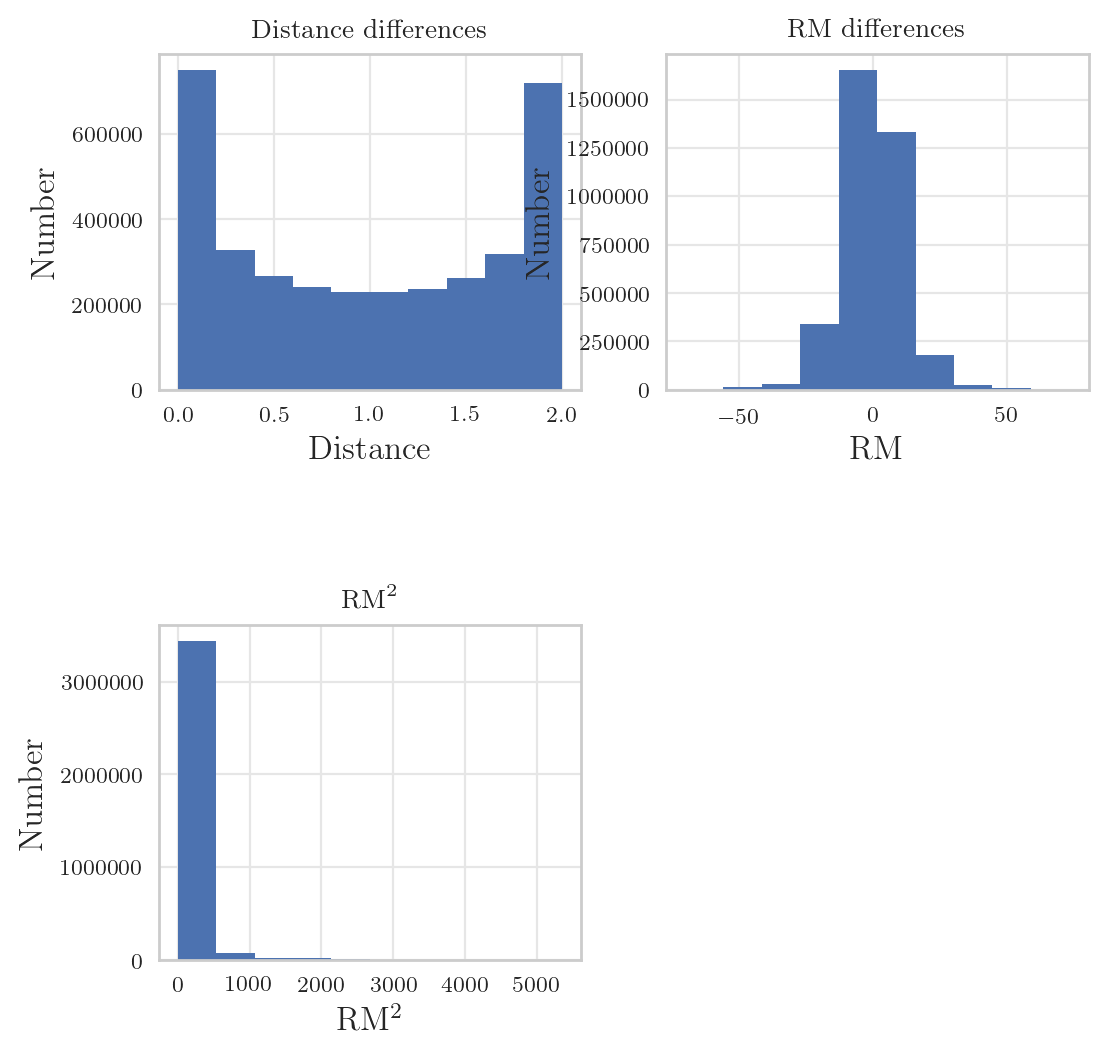

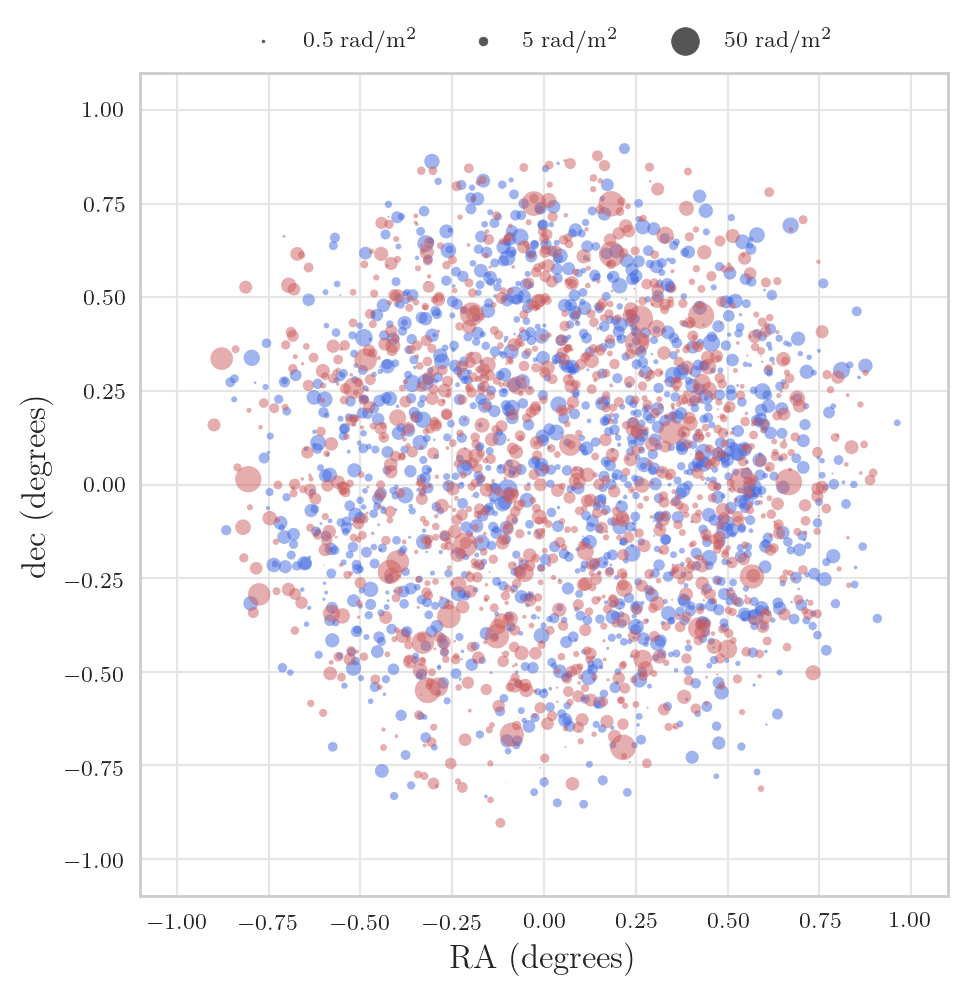

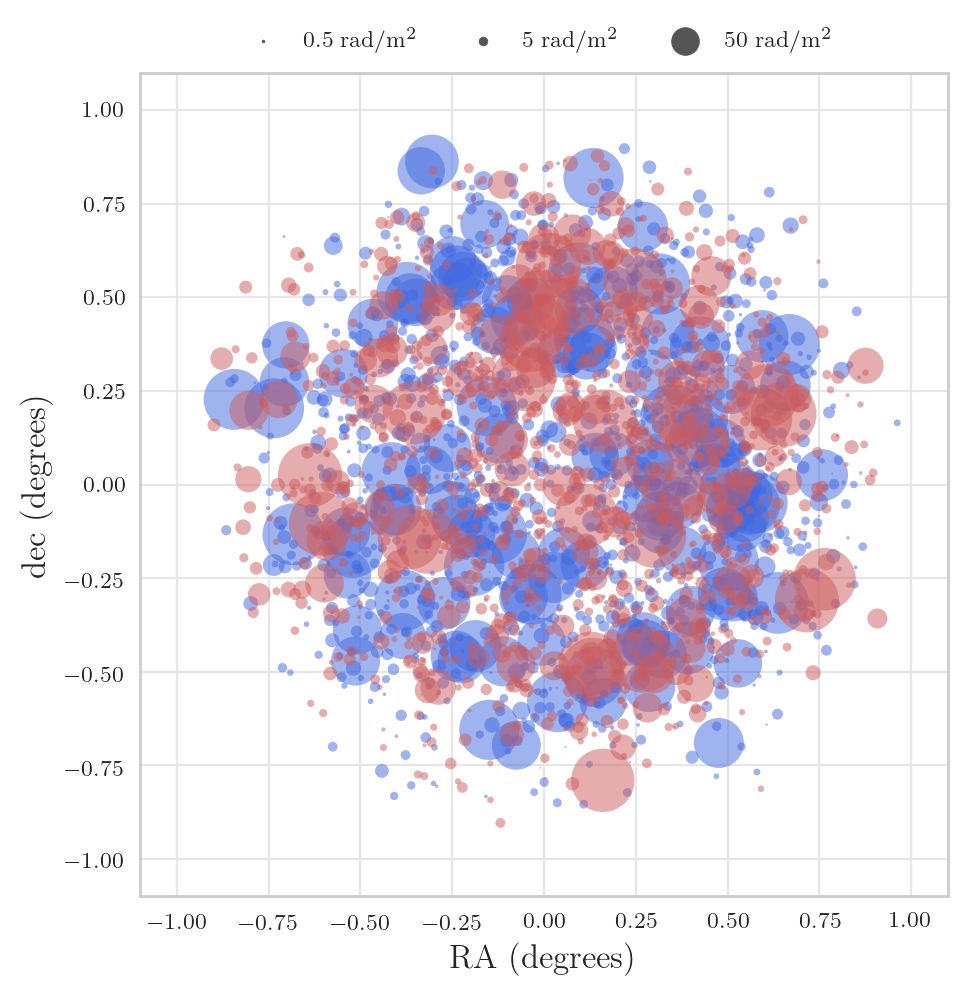

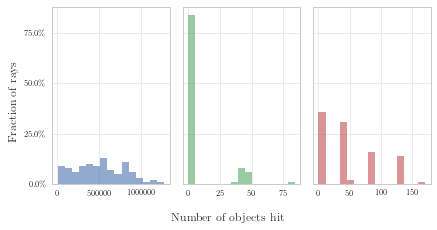

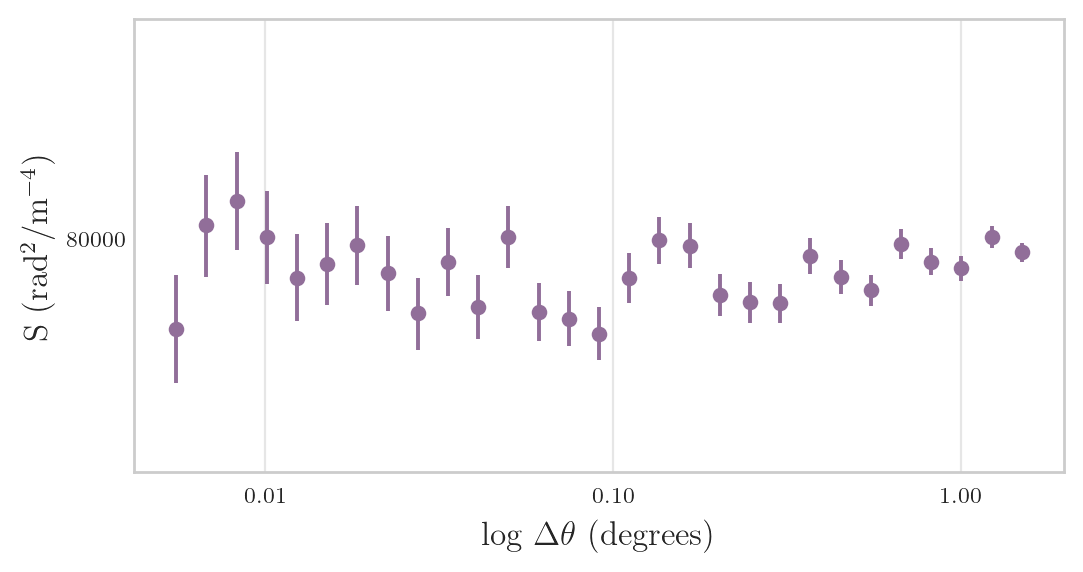

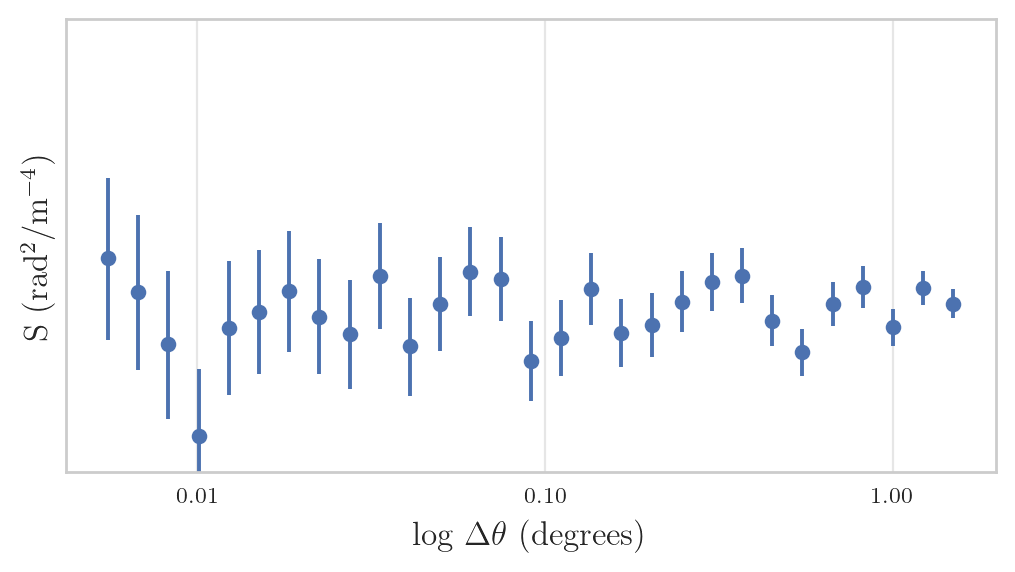

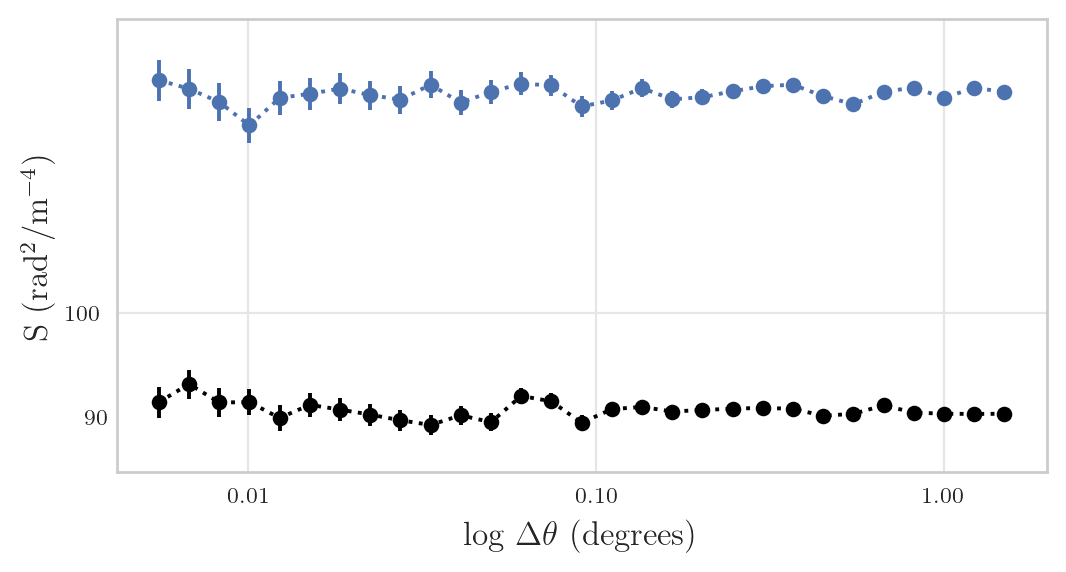

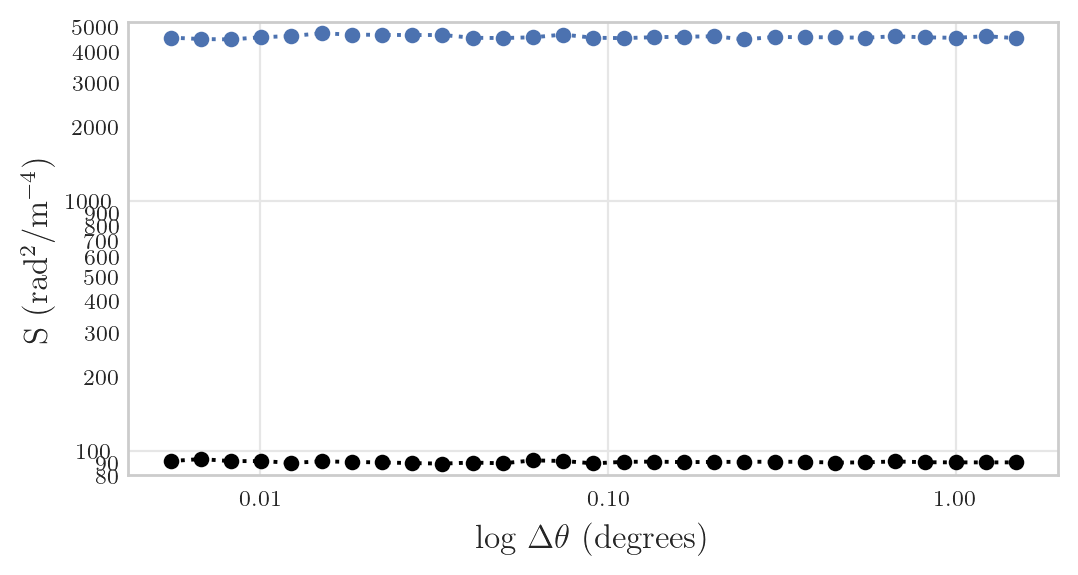

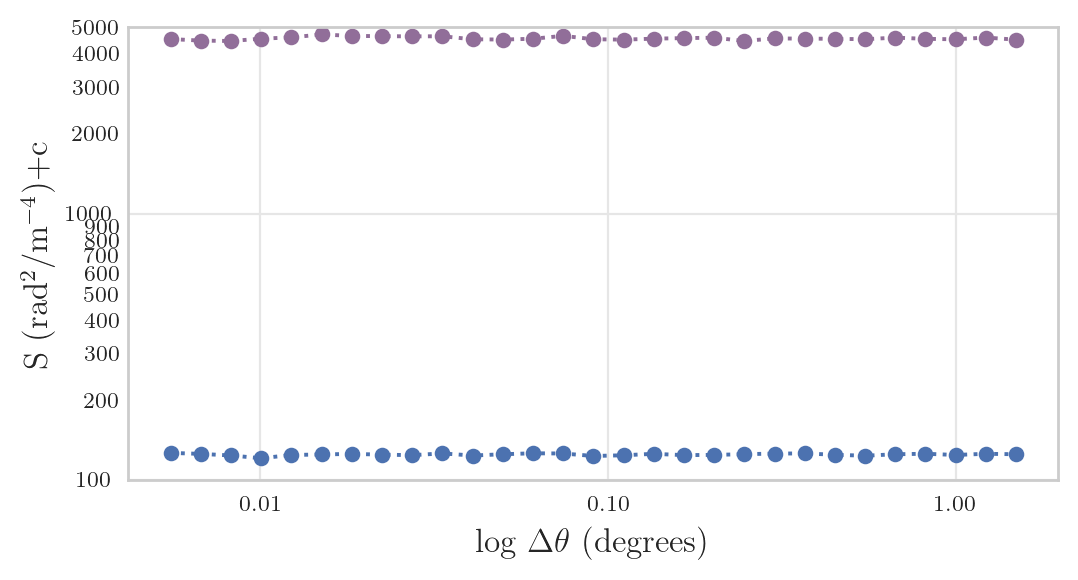

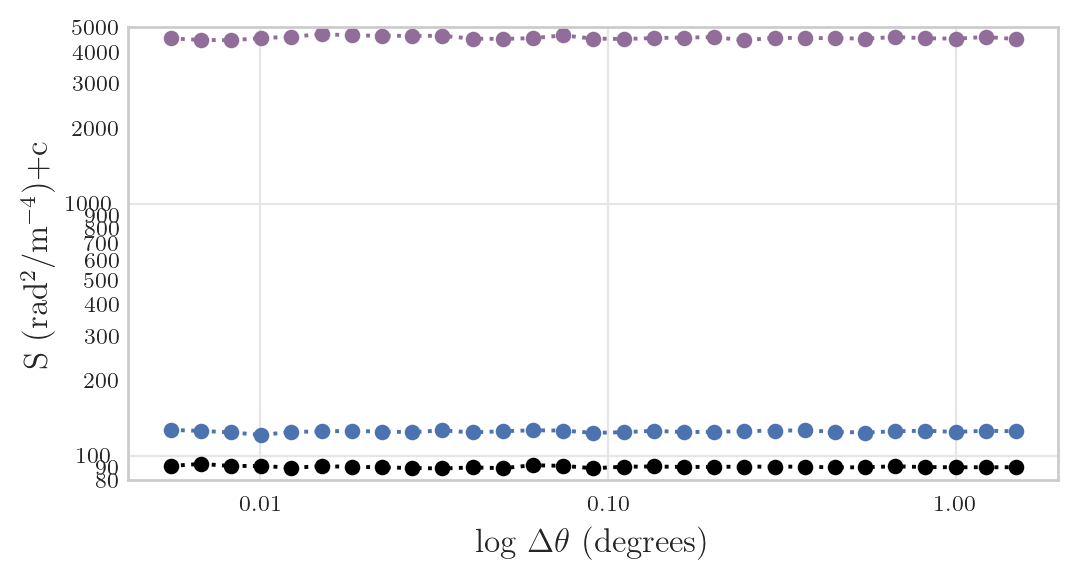

In [35]:
processParameter('1e-08','REALISTIC') 

means [125.08732330875264, 147.47676015175347]


[[0.0014460103951865774,
  125.48096032239542,
  0.0021683703804746502,
  0.16811592769039602],
 [-0.0025310360309291902,
  146.63644547869328,
  0.0031483423766249488,
  0.28630783689861178]]

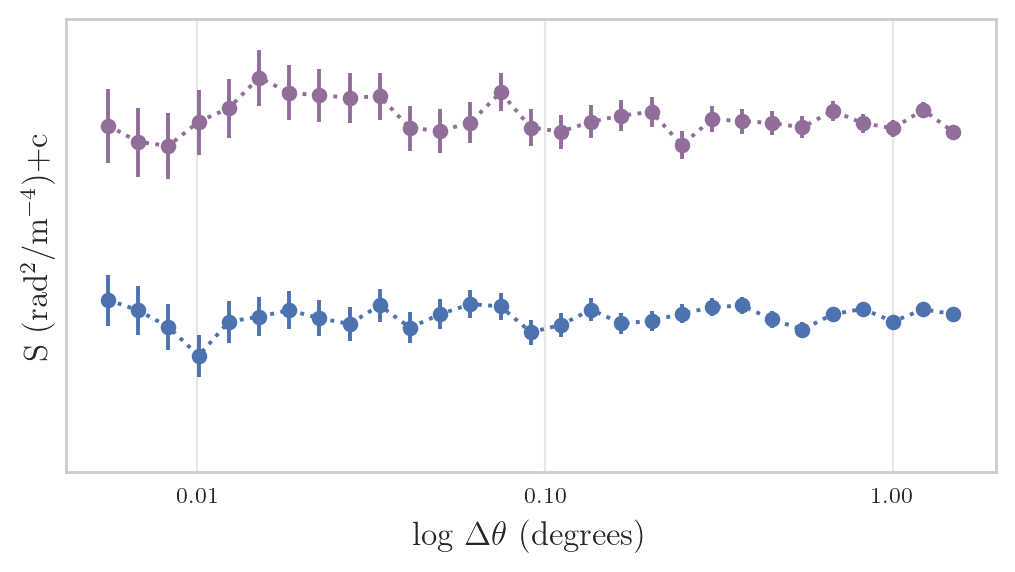

In [36]:
scales = [1,0.18]
compareRMs([totalRM['REALISTIC_1e-08_0.5_5000'],observedRM['REALISTIC_1e-08_0.5_5000']],
           scales,
           [labels['REALISTIC_1e-08_0.5_5000']+' at original scale','observed'],
            [110,160],'CompareScaled_galaxies',
           [colors['REALISTIC_1e-08_0.5_5000'],colorPal['purple']])


In [37]:
processParameter('1e-08','ALIGNED')

outputALIGNED_1e-08_0.5_5000/ ALIGNED_1e-08_0.5_5000
100.0 percent of the files were present
2675


In [38]:
processParameter('1e-08','RANDOM')

outputRANDOM_1e-08_0.5_5000/ RANDOM_1e-08_0.5_5000
100.0 percent of the files were present
2675


# Compare Rays

In [39]:
print fitLine[direction]

[-0.00086138265501367606, 91.908662669095136, 0.0016210922520445245, 0.092602366727497915]


mean SOURCEONLY 90.5923678432
mean REALISTIC_1e-08_0.5_5000 125.087323309
mean RANDOM_1e-08_0.5_5000 92.1308670964
mean ALIGNED_1e-08_0.5_5000 160.169873971
mean SOURCEONLY 90.5923678432
mean REALISTIC_1e-08_0.5_5000 125.087323309
mean REALISTIC_1e-07_0.5_5000 3324.62322624
mean REALISTIC_1e-09_0.5_5000 91.152782086
means [119.80840647266433, 125.08732330875264, 121.8430717349474, 129.73759791682747]


[[-0.00098831391081344311,
  119.4935109587789,
  0.0016193563591573343,
  0.12027878710921491],
 [0.0014460103951865774,
  125.48096032239542,
  0.0021683703804746502,
  0.16811592769039602],
 [-0.00086138057467133322,
  121.54920655064183,
  0.001621089991154937,
  0.12246650125468633],
 [0.0056405039753293362,
  131.34925748047351,
  0.0025723546213141995,
  0.21119856979917692]]

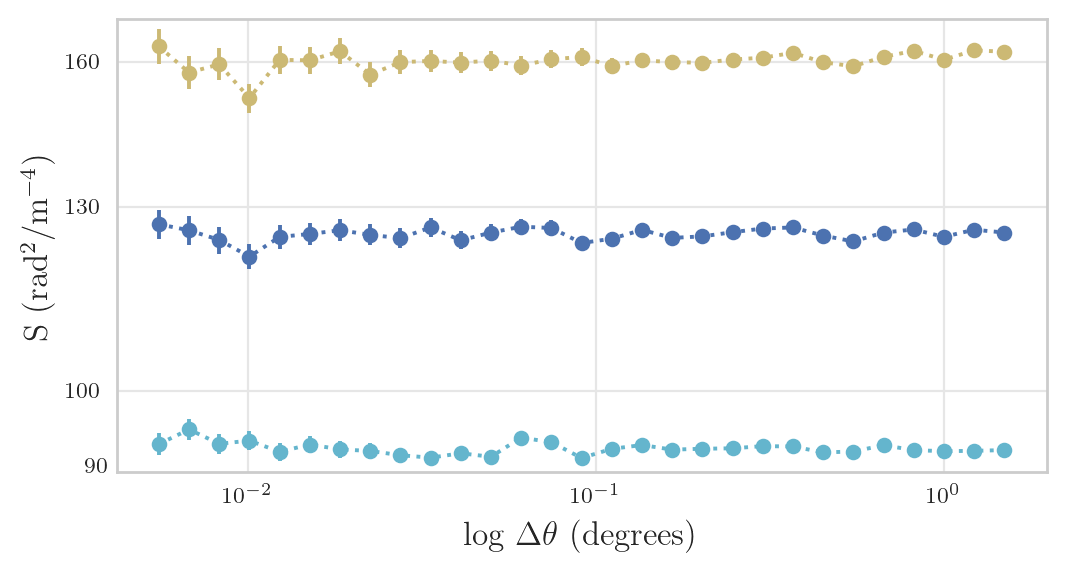

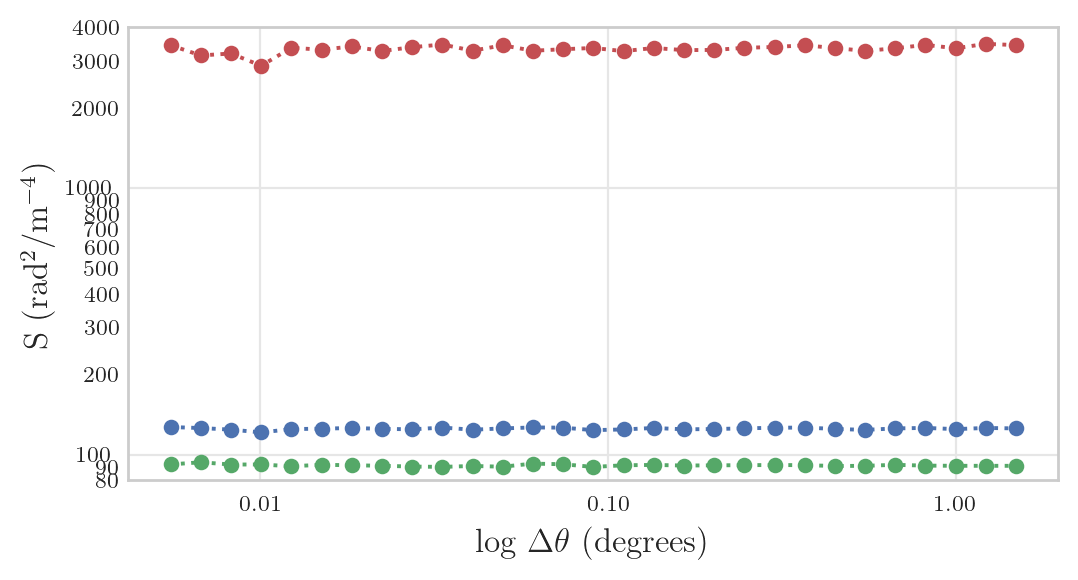

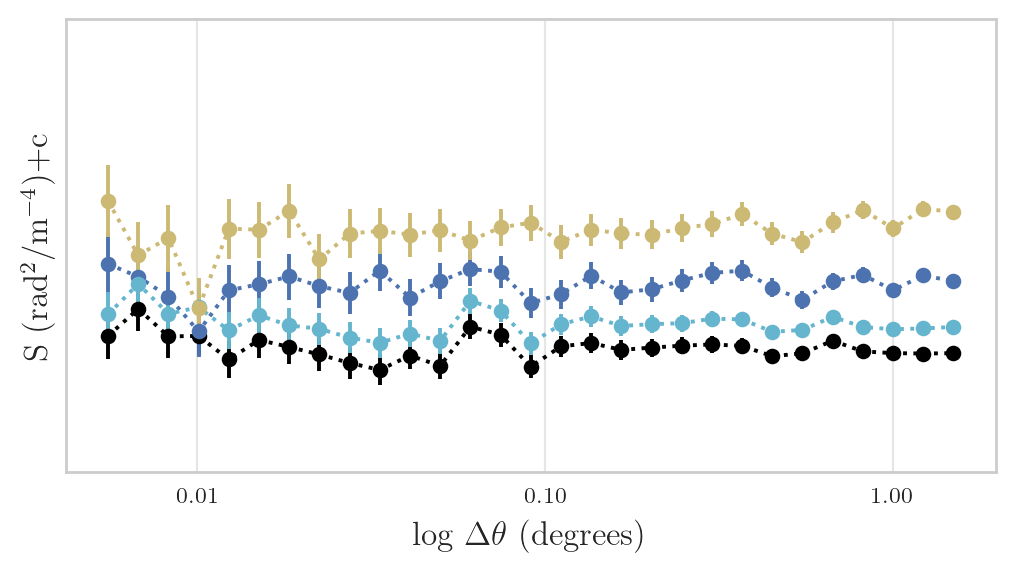

In [40]:
compareBinnedRM((89,170),midpoints,meanValues,rmsAverage,'LSSonly','directions')
compareBinnedRM((80,4000),midpoints,meanValues,rmsAverage,'LSSonly','strengths')
# compareBinnedRM_plusonepoint((85,170),midpoints,meanValues,rmsAverage,'strengths')

scales = [1.15,1,1.15,0.90]
compareRMs([sourceRM,totalRM['REALISTIC_1e-08_0.5_5000'],totalRM['RANDOM_1e-08_0.5_5000'],
            totalRM['ALIGNED_1e-08_0.5_5000']],
           scales,[labels['SOURCEONLY']+' scaled by '+str(scales[0]),
                   labels['REALISTIC_1e-08_0.5_5000']+' at original scale',
                   labels['RANDOM_1e-08_0.5_5000']+' scaled by '+str(scales[2]),
                   labels['ALIGNED_1e-08_0.5_5000']+' scaled by '+str(scales[3])],
           [110,150],'CompareScaledDirections_without_galaxies',
           [colors['SOURCEONLY'],colors['REALISTIC_1e-08_0.5_5000'],colors['RANDOM_1e-08_0.5_5000'],colors['ALIGNED_1e-08_0.5_5000']])


mean SOURCEONLY 90.5923678432
mean REALISTIC_1e-08_0.5_5000 4551.75185654
mean RANDOM_1e-08_0.5_5000 4514.62900994
mean ALIGNED_1e-08_0.5_5000 4538.20068427
mean SOURCEONLY 90.5923678432
mean REALISTIC_1e-08_0.5_5000 4551.75185654
mean REALISTIC_1e-07_0.5_5000 7804.77403024
mean REALISTIC_1e-09_0.5_5000 4512.46868824
means [4188.9910890706997, 4508.0374798672974, 4551.7518565356022, 4512.4686882359374]


[[-0.00098831252195687408,
  4177.9811130897533,
  0.0016193513662529696,
  4.2054356622584921],
 [0.0036091428709669492,
  4545.2474279759754,
  0.0031807701616033304,
  8.9582823791749409],
 [-0.0025310327339589083,
  4525.8162176395272,
  0.0031483290576394601,
  8.836644525986177],
 [-0.0025542672574795596,
  4486.4645659753778,
  0.0031688776789498617,
  8.8181078928405832]]

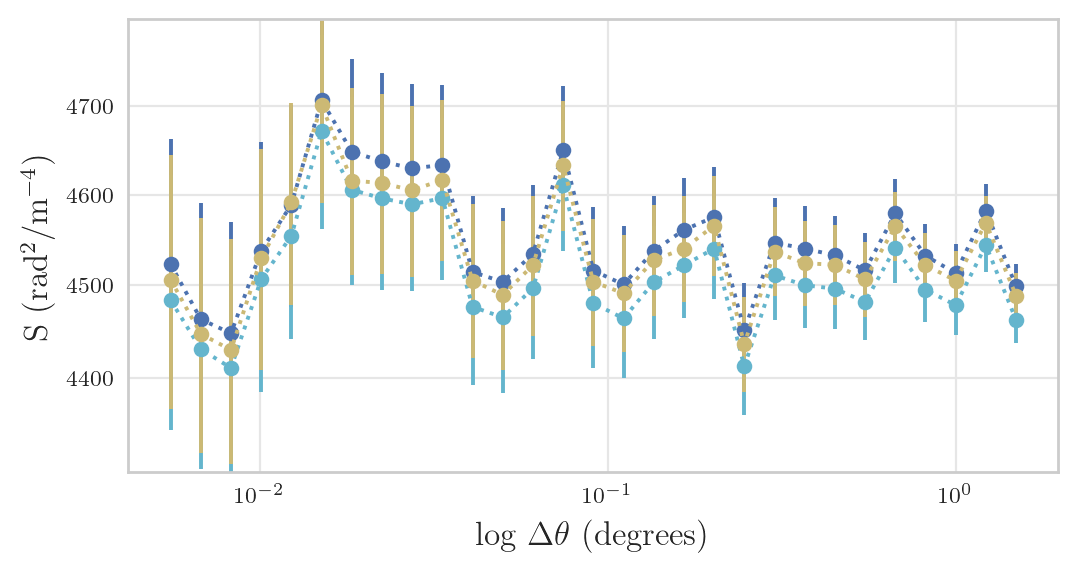

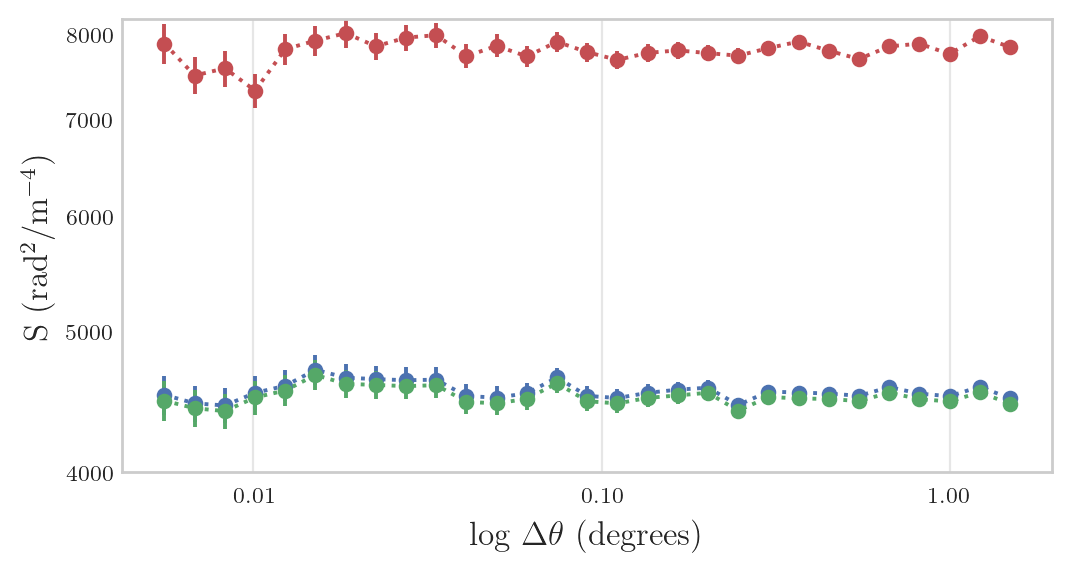

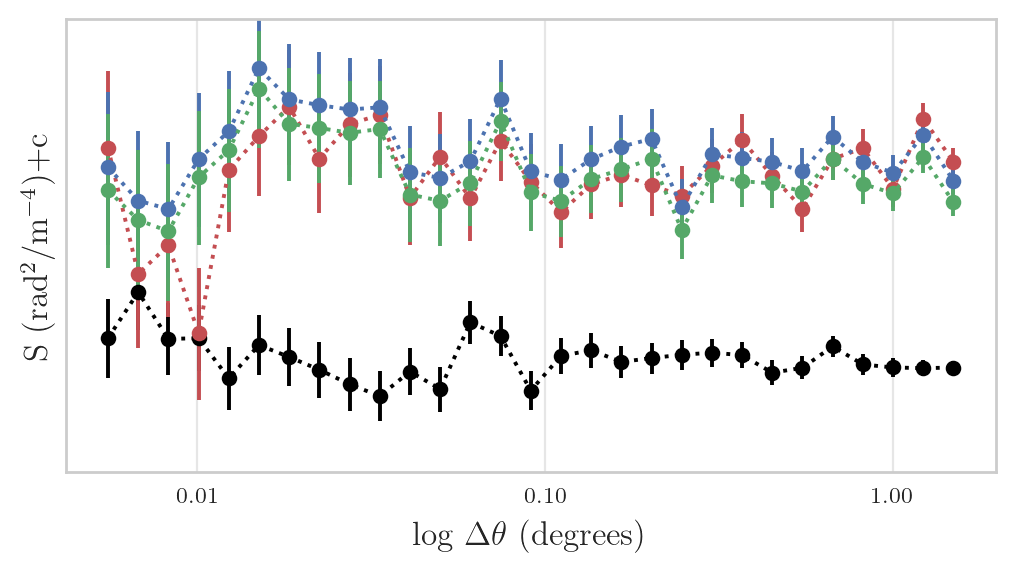

In [41]:
compareBinnedRM((4300,4800),midpoints_obs,meanValues_obs,rmsAverage_obs,'observed','directions')
compareBinnedRM((4000,8200),midpoints_obs,meanValues_obs,rmsAverage_obs,'observed','strengths')
# compareBinnedRM_plusonepoint((85,170),midpoints_obs,meanValues_obs,rmsAverage_obs,'strengths')

scales = [6.8,0.76,1,1]
compareRMs([sourceRM,observedRM['REALISTIC_1e-07_0.5_5000'],
            observedRM['REALISTIC_1e-08_0.5_5000'],observedRM['REALISTIC_1e-09_0.5_5000']],
           scales,[labels['SOURCEONLY']+' scaled by '+str(scales[0]),
                   labels['REALISTIC_1e-07_0.5_5000']+' at original scale',
                   labels['REALISTIC_1e-08_0.5_5000']+' scaled by '+str(scales[2]),
                   labels['REALISTIC_1e-09_0.5_5000']+' scaled by '+str(scales[3])],
           [4001,4800],'CompareScaledStrengths_with_galaxies',
           [colors['SOURCEONLY'],colors['REALISTIC_1e-07_0.5_5000'],colors['REALISTIC_1e-08_0.5_5000'],colors['REALISTIC_1e-09_0.5_5000']])


- if I were to plot y=72, most, but not all of the errorbars will pass through it
- the errorbars are not all the same size because there are a different number of points in each bin

- fill in the space between the source error bars, then plot error bars on results
- measuremnt errors would add a flat structure function that would need to be subtracted before getting results (see structure in the RM sky)
- dont plot sources right to edge of cone
- dont plot structure function right to the end because you might find edge effect errors
- run simulation over range of sources so that I can identify whether the sources/simulation are providing structure
- test the structure function for the total distance covered in 

# Combine all signals with and without LSS

SF$_{\rm Tracing Galaxies}$
SF$_{\rm Tracing LSS}$
SF$_{\rm Observed}$


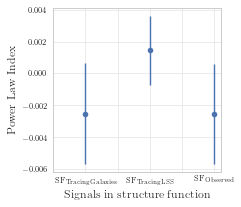

In [42]:
labelList = [r'SF$_{\rm Tracing Galaxies}$',r'SF$_{\rm Tracing LSS}$', r'SF$_{\rm Observed}$']
RMList = [sourceRM+galaxyRM['REALISTIC_1e-08_0.5_5000'],totalRM['REALISTIC_1e-08_0.5_5000'],observedRM['REALISTIC_1e-08_0.5_5000']]

index=[];indexError=[];mv_combined=[];rms_combined=[];fitLine_combined = []
for k in range(len(labelList)):
    distDifferenceNew_c,RMDifferenceJust_c,RMDifferenceNew_c = broadcastingRM(anglePos,RMList[k],numSources)
    midpoints_c,meanValues_c,rmsAverage_c,fitLine_c = binning(distDifferenceNew_c,RMDifferenceNew_c)
    print labelList[k]
    index.append(fitLine_c[0])
    indexError.append(fitLine_c[2])
    mv_combined.append(meanValues_c)
    rms_combined.append(rmsAverage_c)
    fitLine_combined.append(fitLine_c)
    
plt.figure(figsize=(3,3))
plt.errorbar([1,3,5], y=index, yerr=indexError, fmt='o')
plt.xticks(range(len(labelList)+3),['',labelList[0],'',labelList[1],'',labelList[2],''])
plt.ylabel('Power Law Index')
plt.xlabel('Signals in structure function')

plt.savefig('../../Thesis/Figures/SignalSlopes.pdf',bbox_inches='tight')

# Direction slopes

Realistic
Random
Sources
Only
Aligned


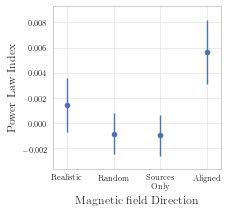

In [43]:
dirLabels=[];index=[];indexError=[]
labDict = {'REALISTIC_1e-08_0.5_5000': 'Realistic', 'SOURCEONLY': 'Sources\nOnly', 'ALIGNED_1e-08_0.5_5000': 'Aligned', 'RANDOM_1e-08_0.5_5000': 'Random'}
for k in fitLine.keys():
    if k == 'SOURCEONLY' or k.split('_')[1]=='1e-08':
        print labDict[k]
        dirLabels.append(labDict[k])
        index.append(fitLine[k][0])
        indexError.append(fitLine[k][2])
    
plt.figure(figsize=(3,3))
plt.errorbar(range(len(dirLabels)), y=index, yerr=indexError, fmt='o')
plt.xticks(range(len(dirLabels)),dirLabels)
plt.margins(x=0.1, y=0.1)
plt.ylabel('Power Law Index')
plt.xlabel('Magnetic field Direction')
plt.savefig('../../Thesis/Figures/DirectionSlopes_withoutGalaxies.pdf',bbox_inches='tight')

Realistic
Random
Sources
Only
Aligned


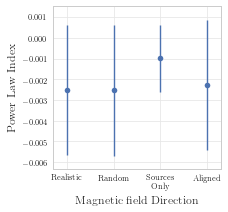

In [44]:
dirLabels=[];index=[];indexError=[]
labDict = {'REALISTIC_1e-08_0.5_5000': 'Realistic', 'SOURCEONLY': 'Sources\nOnly', 'ALIGNED_1e-08_0.5_5000': 'Aligned', 'RANDOM_1e-08_0.5_5000': 'Random'}
for k in fitLine.keys():
    if k == 'SOURCEONLY':
        print labDict[k]
        dirLabels.append(labDict[k])
        index.append(fitLine[k][0])
        indexError.append(fitLine[k][2])
    elif k.split('_')[1]=='1e-08':
        print labDict[k]
        dirLabels.append(labDict[k])
        index.append(fitLine_obs[k][0])
        indexError.append(fitLine_obs[k][2])
    
plt.figure(figsize=(3,3))
plt.errorbar(range(len(dirLabels)), y=index, yerr=indexError, fmt='o')
plt.xticks(range(len(dirLabels)),dirLabels)
plt.margins(x=0.1, y=0.1)
plt.ylabel('Power Law Index')
plt.xlabel('Magnetic field Direction')
plt.savefig('../../Thesis/Figures/DirectionSlopes_observed.pdf',bbox_inches='tight')

# Strength Slopes

In [45]:
print [len(x) for x in totalRM.values()]

[2675, 2675, 2675, 2675, 2675]


1\,nG -0.00112857663891 0.00161731565854
10\,nG 0.00144601039519 0.00216837038047
100\,nG 0.0125431256006 0.00568654088782
Sources
Only -0.000988313164869 0.00161934511024


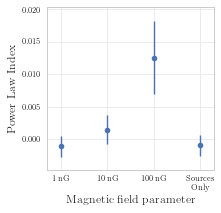

In [46]:
dirLabels=[];index=[];indexError=[]
labDict = {'REALISTIC_1e-08_0.5_5000': r'10\,nG', 'SOURCEONLY': 'Sources\nOnly', 'REALISTIC_1e-07_0.5_5000': r'100\,nG', 'REALISTIC_1e-09_0.5_5000': r'1\,nG'}
for k in fitLine.keys():
    if k == 'SOURCEONLY' or k.split('_')[0]=='REALISTIC':
        print labDict[k],fitLine[k][0],fitLine[k][2]
        dirLabels.append(labDict[k])
        index.append(fitLine[k][0])
        indexError.append(fitLine[k][2])
    

plt.figure(figsize=(3,3))
plt.errorbar(range(len(dirLabels)), y=index, yerr=indexError, fmt='o')
plt.xticks(range(len(dirLabels)),dirLabels)
plt.margins(x=0.1, y=0.1)
plt.ylabel('Power Law Index')
plt.xlabel('Magnetic field parameter')
plt.savefig('../../Thesis/Figures/indexPerParameter_withoutGalaxies.pdf',bbox_inches='tight')

1\,nG
10\,nG
100\,nG
Sources
Only


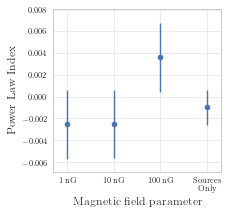

In [47]:
dirLabels=[];index=[];indexError=[]
labDict = {'REALISTIC_1e-08_0.5_5000': r'10\,nG', 'SOURCEONLY': 'Sources\nOnly', 'REALISTIC_1e-07_0.5_5000': r'100\,nG', 'REALISTIC_1e-09_0.5_5000': r'1\,nG'}
for k in fitLine.keys():
    if k == 'SOURCEONLY':
        print labDict[k]
        dirLabels.append(labDict[k])
        index.append(fitLine[k][0])
        indexError.append(fitLine[k][2])
    elif k.split('_')[0]=='REALISTIC':
        print labDict[k]
        dirLabels.append(labDict[k])
        index.append(fitLine_obs[k][0])
        indexError.append(fitLine_obs[k][2])
    
plt.figure(figsize=(3,3))
plt.errorbar(range(len(dirLabels)), y=index, yerr=indexError, fmt='o')
plt.xticks(range(len(dirLabels)),dirLabels)
plt.margins(x=0.1, y=0.1)
plt.ylabel('Power Law Index')
plt.xlabel('Magnetic field parameter')
plt.savefig('../../Thesis/Figures/indexPerParameter_observed.pdf',bbox_inches='tight')

# Save results

In [48]:
import pandas as pd 
print fitLine[direction]

[-0.00086138265501367606, 91.908662669095136, 0.0016210922520445245, 0.092602366727497915]


In [49]:
rms_noGal = pd.read_csv('rms_withoutGalaxies.csv',index_col=0)
rms_noGal['SOURCEONLY'] = rmsAverage['SOURCEONLY']
rms_noGal['sourceWithoutError'] = rAv
for d in observedRM.keys():
    rms_noGal[d] = rmsAverage[d]
rms_noGal.to_csv('rms_withoutGalaxies.csv')
rms_noGal.head()

,ALIGNED_1e-08_0.5_5000,RANDOM_1e-08_0.5_5000,REALISTIC_1e-07_0.5_5000,REALISTIC_1e-08_0.5_5000,REALISTIC_1e-09_0.5_5000,SOURCEONLY,AllButLSS,sourceWithoutError
0,4.054568,1.460364,188.040137,2.681767,1.444813,1.438927,137.091604,1.132071
1,3.665009,1.414708,170.951967,2.539285,1.395626,1.387798,130.590706,1.085215
2,3.641412,1.353416,164.484013,2.393717,1.335061,1.329311,123.838175,1.037577
3,3.170952,1.239042,145.395851,2.137821,1.214925,1.210213,115.063006,0.956731
4,3.306322,1.181297,150.859038,2.167926,1.161590,1.154376,108.572615,0.922537


In [50]:
SF_noGal = pd.read_csv('structurefunctions_withoutGalaxies.csv',index_col=0)
for d in totalRM.keys():
    SF_noGal['Midpoints'] = midpoints['SOURCEONLY']
    SF_noGal['SOURCEONLY'] = meanValues['SOURCEONLY']
    SF_noGal[d] = meanValues[d]
SF_noGal['sourceWithoutError'] = me
SF_noGal.to_csv('structurefunctions_withoutGalaxies.csv')
SF_noGal.head()

,ALIGNED_1e-08_0.5_5000,RANDOM_1e-08_0.5_5000,REALISTIC_1e-07_0.5_5000,REALISTIC_1e-08_0.5_5000,REALISTIC_1e-09_0.5_5000,SOURCEONLY,Midpoints,sourceWithoutError
0,163.558822,92.678279,3430.531182,126.878095,91.895182,91.323370,0.005553,72.424361
1,157.578104,94.637465,3140.465346,125.778074,93.585668,93.030915,0.006780,73.217449
2,159.447953,92.721025,3194.390389,124.075007,91.800370,91.297990,0.008279,72.876233
3,151.944355,93.135287,2873.550015,121.145963,91.821341,91.323048,0.010109,72.068706
4,160.462181,91.671217,3356.365111,124.608556,90.418659,89.863168,0.012344,71.793276


In [51]:
rms = pd.read_csv('rms.csv',index_col=0)
rms.describe()
rms['SOURCEONLY'] = rmsAverage['SOURCEONLY']
rms['sourceWithoutError'] = rAv
for d in observedRM.keys():
    rms[d] = rmsAverage_obs[d]
rms['AllButLSS'] = rms_combined[0]
rms.to_csv('rms.csv')
rms.describe()

,ALIGNED_1e-08_0.5_5000,RANDOM_1e-08_0.5_5000,REALISTIC_1e-07_0.5_5000,REALISTIC_1e-08_0.5_5000,REALISTIC_1e-09_0.5_5000,SOURCEONLY,sourceWithoutError,AllButLSS
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,71.828972,71.777687,124.344134,71.939553,71.782844,0.736449,0.582172,71.773021
std,34.189992,34.157962,58.769965,34.235619,34.161022,0.355100,0.279594,34.156190
min,15.469298,15.459883,27.412745,15.493558,15.460285,0.160023,0.126530,15.458373
25%,44.474138,44.424090,77.634117,44.520254,44.426954,0.456354,0.361565,44.421393
50%,66.778005,66.727882,115.686346,66.890127,66.733995,0.678783,0.537455,66.724221
75%,99.370546,99.423235,169.788120,99.669952,99.437722,0.986962,0.788646,99.421268
max,138.949220,138.713399,247.028502,139.030955,138.676731,1.438927,1.132071,138.657287


In [52]:
SF = pd.read_csv('structurefunctions.csv',index_col=0)
for d in observedRM.keys():
    SF['Midpoints'] = midpoints['SOURCEONLY']
    SF[d] = meanValues_obs[d]
SF['SOURCEONLY'] = meanValues['SOURCEONLY']
SF['sourceWithoutError'] = me
SF['AllButLSS'] = mv_combined[0]
SF.to_csv('structurefunctions.csv')
SF.head()

,ALIGNED_1e-08_0.5_5000,RANDOM_1e-08_0.5_5000,REALISTIC_1e-07_0.5_5000,REALISTIC_1e-08_0.5_5000,REALISTIC_1e-09_0.5_5000,Midpoints,SOURCEONLY,AllButLSS,sourceWithoutError
0,4505.977121,4483.683486,7892.753278,4523.123621,4481.543051,0.005553,91.323370,4480.238166,72.424361
1,4447.175711,4430.768493,7502.567222,4462.919783,4428.231360,0.006780,93.030915,4427.399272,73.217449
2,4429.796166,4410.422907,7589.389483,4447.731283,4408.322363,0.008279,91.297990,4407.027286,72.876233
3,4529.608537,4506.630480,7325.723367,4537.803825,4504.927655,0.010109,91.323048,4504.034745,72.068706
4,4591.317766,4554.369841,7822.618452,4588.834478,4554.441838,0.012344,89.863168,4553.863821,71.793276


In [53]:
stat = pd.read_csv('statistics.csv',index_col=0)
stat.head()

,Key,mean_difference,std_difference,variance_difference,power_index,amplitude,indexError,amplitudeError,mean_RMS_average
0,SOURCEONLY,0.000000,0.000000,0.000000,-0.000988,90.354263,0.001619,0.090948,0.736449
1,sourceWithoutError,0.000000,0.000000,0.000000,-0.000090,72.022624,0.001609,0.071926,0.582172
2,allButLSS,0.000000,0.000000,0.000000,-0.002545,4485.403080,0.003169,8.817008,71.773021
3,REALISTIC_1e-08_0.5_5000,4459.852134,61.410730,3771.277809,-0.002531,4525.816213,0.003148,8.836620,71.939553
4,RANDOM_1e-08_0.5_5000,4422.727272,60.682569,3682.374179,-0.002535,4488.802036,0.003167,8.817656,71.777687


In [54]:
keys = []
diff = []
stddev = []
mean = []
variance = []
angleDist = []

print fitLine['SOURCEONLY']

def insertStats(key,rmsAverage,fitLine,meanValues):
    global stat
    locn = stat.Key.where(stat.Key == key).dropna().index
    stat.set_value(locn,'mean_RMS_average',np.mean(rmsAverage))
    stat.set_value(locn,'mean_difference',0)
    stat.set_value(locn,'std_difference',0)
    stat.set_value(locn,'variance_difference',0) 
    stat.set_value(locn,'power_index',fitLine[0]) 
    stat.set_value(locn,'amplitude',fitLine[1]) 
    stat.set_value(locn,'indexError',fitLine[2]) 
    stat.set_value(locn,'amplitudeError',fitLine[3]) 
    
print observedRM.keys()
insertStats('SOURCEONLY',rmsAverage['SOURCEONLY'],fitLine['SOURCEONLY'],meanValues['SOURCEONLY'])
insertStats('sourceWithoutError',rAv,fL,me)
insertStats('allButLSS',rms['AllButLSS'],fitLine_combined[0],SF['AllButLSS'])
# locn = stat.Key.where(stat.Key == 'SOURCEONLY').dropna().index 
# stat.set_value(locn,'Key','SOURCEONLY')
# stat.set_value(locn,'mean_RMS_average',np.mean(rmsAverage['SOURCEONLY']))
# stat.set_value(locn,'mean_difference',0)
# stat.set_value(locn,'std_difference',0)
# stat.set_value(locn,'variance_difference',0) 
# stat.set_value(locn,'power_index',fitLine['SOURCEONLY'][0]) 
# stat.set_value(locn,'amplitude',fitLine['SOURCEONLY'][1]) 
# stat.set_value(locn,'indexError',fitLine['SOURCEONLY'][2]) 
# stat.set_value(locn,'amplitudeError',fitLine['SOURCEONLY'][3]) 
for d in observedRM.keys():   
    key = d
    locn = stat.Key.where(stat.Key == key).dropna().index
    if locn == -1 or len(list(locn))==0:
        locn = stat.shape[0]+1   
    stat.set_value(locn,'Key',key)
    difference = meanValues_obs[d]-meanValues_obs['SOURCEONLY']
    stat.set_value(locn,'mean_RMS_average',np.mean(rmsAverage_obs[d]))
    stat.set_value(locn,'mean_difference',np.mean(difference))
    stat.set_value(locn,'std_difference',np.std(difference))
    stat.set_value(locn,'variance_difference',np.var(difference))
    stat.set_value(locn,'power_index',fitLine_obs[d][0]) 
    stat.set_value(locn,'amplitude',fitLine_obs[d][1]) 
    stat.set_value(locn,'indexError',fitLine_obs[d][2]) 
    stat.set_value(locn,'amplitudeError',fitLine_obs[d][3]) 
stat.to_csv('statistics.csv')
stat

[-0.00098831316486880372, 90.354261929355943, 0.0016193451102441934, 0.090947805922586333]
['REALISTIC_1e-09_0.5_5000', 'REALISTIC_1e-08_0.5_5000', 'REALISTIC_1e-07_0.5_5000', 'ALIGNED_1e-08_0.5_5000', 'RANDOM_1e-08_0.5_5000']


,Key,mean_difference,std_difference,variance_difference,power_index,amplitude,indexError,amplitudeError,mean_RMS_average
0,SOURCEONLY,0.000000,0.000000,0.000000,-0.000988,90.354262,0.001619,0.090948,0.736449
1,sourceWithoutError,0.000000,0.000000,0.000000,-0.000090,72.022624,0.001609,0.071929,0.582172
2,allButLSS,0.000000,0.000000,0.000000,-0.002545,4485.403092,0.003169,8.817028,71.773021
3,REALISTIC_1e-08_0.5_5000,4459.852134,61.410730,3771.277809,-0.002531,4525.816218,0.003148,8.836645,71.939553
4,RANDOM_1e-08_0.5_5000,4422.727272,60.682569,3682.374179,-0.002535,4488.802091,0.003167,8.817687,71.777687
5,ALIGNED_1e-08_0.5_5000,4446.425602,60.237333,3628.536338,-0.002277,4514.956972,0.003153,8.822894,71.828972
6,REALISTIC_1e-07_0.5_5000,7717.620780,145.361357,21129.924032,0.003609,7869.195726,0.003181,15.509513,124.344134
7,REALISTIC_1e-09_0.5_5000,4420.555910,60.576996,3669.572470,-0.002554,4486.464566,0.003169,8.818108,71.782844


In [55]:
RMvals = [totalRM['REALISTIC_1e-08_0.5_5000'],observedRM['REALISTIC_1e-08_0.5_5000'],galaxyRM['REALISTIC_1e-08_0.5_5000'],sourceRM,sourceRM+galaxyRM['REALISTIC_1e-08_0.5_5000'],observedRM['REALISTIC_1e-07_0.5_5000']]
print [len(i[:,0]) for i in RMvals]
Labels = ['tracingLSS','observed','galaxy','source','tracingGalaxy','100nG']
RMDict = {Labels[k]:RMvals[k][:,0] for k in range(len(Labels))}
RMDict = pd.DataFrame(RMDict)
RMDict.to_csv('RMvals.csv')


[2675, 2675, 2675, 2675, 2675, 2675]


In [56]:
def sTn(rms1,sf1,rms2,sf2,saveExt):
    sTn1 = (sf1 - np.mean(sf1))/rms1
    sTn2 = (sf2 - np.mean(sf2))/rms2
    print len(sTn1),len(sTn2)
    plt.figure(figsize=(6,3))
    binwidth = 0.25
    plt.hist(sTn1, bins=np.arange(np.min(sTn1), np.max(sTn1) + binwidth,binwidth),alpha=0.3)
    plt.hist(sTn2, bins=np.arange(np.min(sTn2), np.max(sTn2) + binwidth,binwidth),alpha=0.3)
    x = np.linspace(-4,4,100) #np.linspace(np.min((np.min(sTn1),np.min(sTn2)))-binwidth,np.max((np.max(sTn1),np.max(sTn2)))+binwidth,100)
    sigGauss = 1.0
    muGauss = 0.0
    fx = binwidth*len(sTn1)/(np.sqrt(2*np.pi*sigGauss**2))*np.exp(-(x**2)/(2.0*sigGauss**2))
    plt.plot(x,fx)          
    plt.xlabel(r'$\delta$')
    plt.ylabel('Count')
    (mu1, sigma1) = norm.fit(sTn1)
    print 'mu1',mu1
    print 'sigma1',sigma1
    (mu2, sigma2) = norm.fit(sTn2)
    print 'mu2',mu2
    print 'sigma2',sigma2
#     plt.legend()
    plt.savefig('../../Thesis/Figures/sTn_'+saveExt+'.pdf',bbox_inches='tight')
    
    return sigma1,mu1,sigma2,mu2

30 30
mu1 -0.170729425553
sigma1 0.950185995546
mu2 0.116201134651
sigma2 0.913728283888


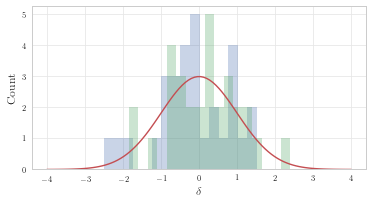

In [57]:
sigma_tracingGal,mu_tracingGal,sigma_tracingLSS,mu_TracingLSS = sTn(rms['AllButLSS'],SF['AllButLSS'],rmsAverage['REALISTIC_1e-08_0.5_5000'],meanValues['REALISTIC_1e-08_0.5_5000'],'traceGal_traceLSS')


30 30
mu1 -0.170729425553
sigma1 0.950185995546
mu2 -0.171317007645
sigma2 0.951939636334
--
30 30
mu1 -0.170729425553
sigma1 0.950185995546
mu2 -0.170607094384
sigma2 0.959508459264
--
30 30
mu1 -0.170729425553
sigma1 0.950185995546
mu2 0.22234558721
sigma2 1.26720662091


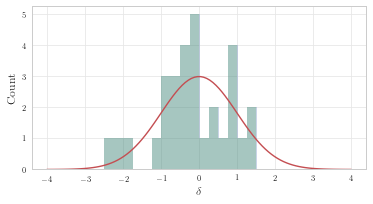

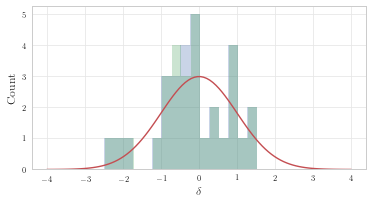

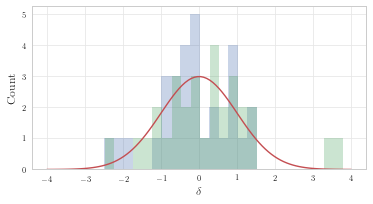

In [58]:
sigma_tracingGal,mu_tracingGal,sigma_obs2p0_1ng,mu_obs2p0_1ng = sTn(rms['AllButLSS'],SF['AllButLSS'],rms['REALISTIC_1e-09_0.5_5000'],SF['REALISTIC_1e-09_0.5_5000'],'comparison_withLSS_1')
print '--'
sigma_tracingGal,mu_tracingGal,sigma_obs2p0_10ng,mu_obs2p0_10ng = sTn(rms['AllButLSS'],SF['AllButLSS'],rms['REALISTIC_1e-08_0.5_5000'],SF['REALISTIC_1e-08_0.5_5000'],'comparison_withLSS_10')
print '--'
sigma_tracingGal,mu_tracingGal,sigma_obs2p0_100ng,mu_obs2p0_100ng = sTn(rms['AllButLSS'],SF['AllButLSS'],rms['REALISTIC_1e-07_0.5_5000'],SF['REALISTIC_1e-07_0.5_5000'],'comparison_withLSS_100')

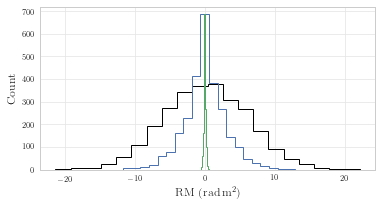

In [59]:
plt.figure(figsize=(6,3))
plt.hist(sourceRM_beforeError,alpha=1,bins=20,histtype='step',color='k',linewidth=1)
plt.hist(RMerror_2p0,alpha=1,bins=20,histtype='step',linewidth=1)
plt.hist(RMerror_0p1,alpha=1,bins=20,histtype='step',linewidth=1)
plt.xlabel(r'RM (rad\,m$^{2}$)')
plt.ylabel('Count')
plt.savefig('../../Thesis/Figures/hist_sourceAndError.pdf',bbox_inches='tight')


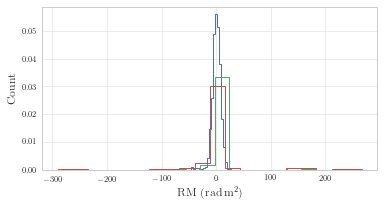

In [60]:
plt.figure(figsize=(6,3))
plt.hist(totalRM['REALISTIC_1e-08_0.5_5000'],alpha=1,bins=20,histtype='step',linewidth=1,normed=True)
plt.hist(galaxyRM['REALISTIC_1e-08_0.5_5000'],alpha=1,bins=20,histtype='step',linewidth=1,normed=True)
plt.hist(observedRM['REALISTIC_1e-08_0.5_5000'],alpha=1,bins=20,histtype='step',linewidth=1,normed=True)
plt.xlabel(r'RM (rad\,m$^{2}$)')
plt.ylabel('Count')
plt.savefig('../../Thesis/Figures/hist_LSSAndGalaxy.pdf',bbox_inches='tight')    

30 30
mu1 -0.0824612825561
sigma1 0.773779903383
mu2 -0.191380977392
sigma2 0.952913870517
30 30
30


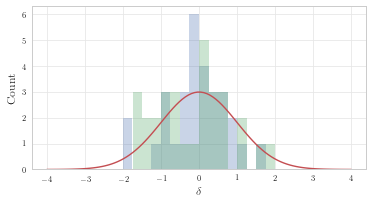

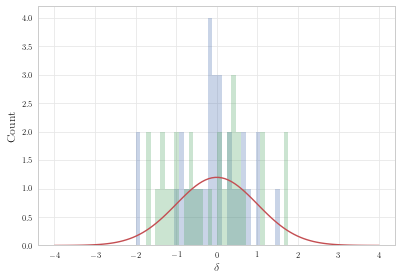

In [61]:
sigma_withoutError,mu_withoutError,sigma_source_error,mu_source_error = sTn(rms['sourceWithoutError'],SF['sourceWithoutError'],rms['SOURCEONLY'],SF['SOURCEONLY'],'comparison_sourceAndError')

plt.figure()
swe = (SF['sourceWithoutError'] - np.mean(SF['sourceWithoutError']))/rms['sourceWithoutError']
so = (SF['SOURCEONLY'] - np.mean(SF['SOURCEONLY']))/rms['SOURCEONLY']
print len(swe),len(so)
plt.hist(swe,bins = 30,alpha=0.3)
plt.hist(so,bins = 30,alpha=0.3)
l = len(SF['sourceWithoutError'])
print l
x = np.linspace(-4,4,100)
sigGauss = 1.0
muGauss = 0.0
fx = 0.1*30.0/(np.sqrt(2*np.pi*sigGauss**2))*np.exp(-(x**2)/(2.0*sigGauss**2))
plt.plot(x,fx)
plt.xlabel(r'$\delta$')
plt.ylabel('Count')
plt.savefig('../../Thesis/Figures/sTn_sourcesGaussian.pdf',bbox_inches='tight')

[-0.011177942688777861, 1809.7316877956914, 0.0052815425609162026, 5.9826482279507234]
30 30
mu1 -0.170607094384
sigma1 0.959508459264
mu2 -0.419902044125
sigma2 1.60982079893


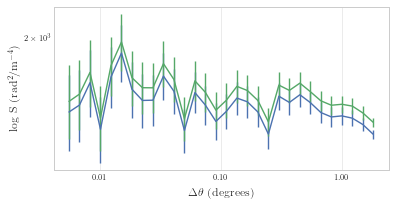

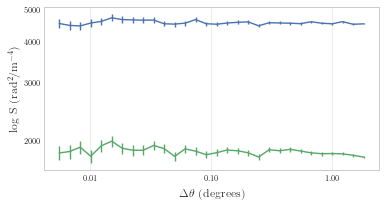

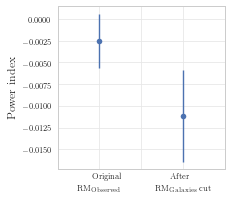

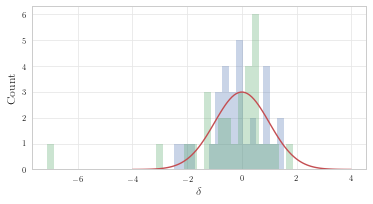

In [62]:
galaxy_cut100_loc = np.where(np.abs(galaxyRM['REALISTIC_1e-08_0.5_5000']<100))[0]
totalRM_cut100 = totalRM['REALISTIC_1e-08_0.5_5000'][galaxy_cut100_loc,:]
observedRM_cut100 = observedRM['REALISTIC_1e-08_0.5_5000'][galaxy_cut100_loc,:]
galaxyRM_cut100 = galaxyRM['REALISTIC_1e-08_0.5_5000'][galaxy_cut100_loc,:]
sourceRM_cut100 = sourceRM[galaxy_cut100_loc,:]
allButLSS_cut100 = sourceRM_cut100+galaxyRM_cut100
anglePos_cut100 = anglePos[galaxy_cut100_loc,:]

cutLabels = ['tracingLSS','observed','galaxy','source','tracingGalaxy']
RMcuts = [totalRM_cut100,observedRM_cut100,galaxyRM_cut100,sourceRM_cut100,allButLSS_cut100]
cut100 = {cutLabels[k]:RMcuts[k][:,0] for k in range(len(cutLabels))}
cut100_SF = {}
for n in range(len(cutLabels)):
    temp = SFCalculations(anglePos_cut100,RMcuts[n])
    cut100_SF[cutLabels[n]]= {'mid':temp[0],'mean':temp[1],'rms':temp[2],'fit':temp[3]}
    
print cut100_SF['observed']['fit']

plt.figure(figsize = (6,3))
ax= plt.subplot(111)
plt.errorbar(cut100_SF['source']['mid'],cut100_SF['tracingGalaxy']['mean'], yerr =cut100_SF['tracingGalaxy']['rms'] )
plt.errorbar(cut100_SF['source']['mid'],cut100_SF['observed']['mean'], yerr = cut100_SF['observed']['rms'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\Delta\theta$ (degrees)")
plt.ylabel(r'log S (rad$^2$/m$^{-4}$)')
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%d")) 
plt.savefig('../../Thesis/Figures/SF_cutGalaxies100vLSS.pdf',bbox_inches='tight')

plt.figure(figsize = (6,3))
ax= plt.subplot(111)
plt.errorbar(midpoints['REALISTIC_1e-08_0.5_5000'],meanValues_obs['REALISTIC_1e-08_0.5_5000'],yerr = rmsAverage_obs['REALISTIC_1e-08_0.5_5000'] )
plt.errorbar(cut100_SF['source']['mid'],cut100_SF['observed']['mean'], yerr = cut100_SF['observed']['rms'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\Delta\theta$ (degrees)")
plt.ylabel(r'log S (rad$^2$/m$^{-4}$)')
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%d")) 
plt.savefig('../../Thesis/Figures/SF_cutGalaxies100.pdf',bbox_inches='tight')

plt.figure(figsize = (3,3))
ax= plt.subplot(111)
ax.errorbar(x = [1,3], y = [fitLine_obs['REALISTIC_1e-08_0.5_5000'][0], cut100_SF['observed']['fit'][0]], yerr = [fitLine_obs['REALISTIC_1e-08_0.5_5000'][2], cut100_SF['observed']['fit'][2]],marker = 'o' ,linestyle='none')
plt.xlim(0,4)
plt.ylabel('Power index')
ax.set_xticklabels(['',r'Original \\RM$_{\rm Observed}$','',r'After \\RM$_{\rm Galaxies}$ cut',''])
plt.savefig('../../Thesis/Figures/powerindex_cutGalaxies100.pdf',bbox_inches='tight')

sigma_obs2p0_01ng,mu_obs2p0_10ng, sigma_obs2p0_10ng_cut100,mu_obs2p0_10ng_cut100 = sTn(rmsAverage_obs['REALISTIC_1e-08_0.5_5000'],meanValues_obs['REALISTIC_1e-08_0.5_5000'],cut100_SF['observed']['rms'],cut100_SF['observed']['mean'],'galaxyCuts')



In [63]:
np.savetxt('anglePos_cut100.txt',anglePos_cut100)

cut100 = pd.DataFrame(cut100)
cut100.to_csv('cut100.csv')

cut100_SF = pd.DataFrame(cut100_SF)
cut100_SF.to_csv('cut100_SF.csv')

[2675, 2675, 2675, 2675, 2675]
[-0.0028022938194000755, 4498.2408597885833, 0.003159846204444503, 8.8147797595595918]
30 30
mu1 -0.170607094384
sigma1 0.959508459264
mu2 -0.188151975421
sigma2 0.994267706289


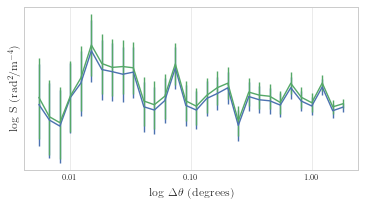

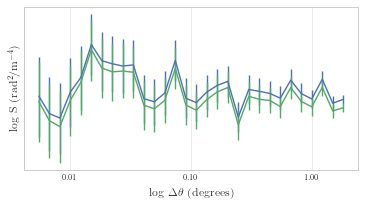

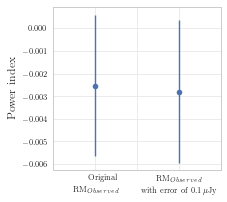

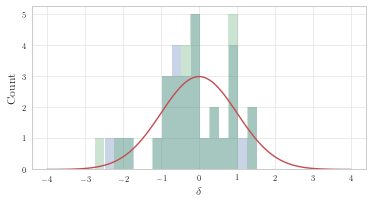

In [64]:
totalRM_0p1 = sourceRM_beforeError+RMerror_0p1+overallRM['REALISTIC_1e-08_0.5_5000']
observedRM_0p1 = sourceRM_beforeError+RMerror_0p1+overallRM['REALISTIC_1e-08_0.5_5000']+galaxyRM['REALISTIC_1e-08_0.5_5000']
galaxyRM_0p1 = galaxyRM['REALISTIC_1e-08_0.5_5000']
sourceRM_0p1 = sourceRM
allButLSS_0p1 = sourceRM_0p1+galaxyRM_0p1
anglePos_0p1 = anglePos

cutLabels = ['tracingLSS','observed','galaxy','source','tracingGalaxy']
RMcuts = [totalRM_0p1,observedRM_0p1,galaxyRM_0p1,sourceRM_0p1,allButLSS_0p1]
print [len(i[:,0]) for i in RMcuts]
RM_0p1 = {cutLabels[k]:RMcuts[k][:,0] for k in range(len(cutLabels))}
SF_0p1 = {}
for n in range(len(cutLabels)):
    temp = SFCalculations(anglePos_0p1,RMcuts[n])
    SF_0p1[cutLabels[n]]= {'mid':temp[0],'mean':temp[1],'rms':temp[2],'fit':temp[3]}
    
print SF_0p1['observed']['fit']

plt.figure(figsize = (6,3))
ax= plt.subplot(111)
plt.errorbar(SF_0p1['source']['mid'],SF_0p1['tracingGalaxy']['mean'], yerr =SF_0p1['tracingGalaxy']['rms'] )
plt.errorbar(SF_0p1['source']['mid'],SF_0p1['observed']['mean'], yerr = SF_0p1['observed']['rms'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"log $\Delta\theta$ (degrees)")
plt.ylabel(r'log S (rad$^2$/m$^{-4}$)')
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%d")) 
plt.savefig('../../Thesis/Figures/SF_error0p1vLSS.pdf',bbox_inches='tight')

plt.figure(figsize = (6,3))
ax= plt.subplot(111)
plt.errorbar(midpoints['REALISTIC_1e-08_0.5_5000'],meanValues_obs['REALISTIC_1e-08_0.5_5000'],yerr = rmsAverage_obs['REALISTIC_1e-08_0.5_5000'] )
plt.errorbar(SF_0p1['source']['mid'],SF_0p1['observed']['mean'], yerr = SF_0p1['observed']['rms'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"log $\Delta\theta$ (degrees)")
plt.ylabel(r'log S (rad$^2$/m$^{-4}$)')
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%d")) 
plt.savefig('../../Thesis/Figures/SF_error0p1.pdf',bbox_inches='tight')

plt.figure(figsize = (3,3))
ax= plt.subplot(111)
ax.errorbar(x = [1,3], y = [fitLine_obs['REALISTIC_1e-08_0.5_5000'][0], SF_0p1['observed']['fit'][0]], yerr = [fitLine_obs['REALISTIC_1e-08_0.5_5000'][2], SF_0p1['observed']['fit'][2]],marker = 'o' ,linestyle='none')
plt.xlim(0,4)
plt.ylabel('Power index')
ax.set_xticklabels(['',r'Original \\RM$_\text{Observed}$','',r'RM$_\text{Observed}$ \\with error of 0.1\,$\mu$Jy',''])
plt.savefig('../../Thesis/Figures/powerindex_error0p1.pdf',bbox_inches='tight')

sigma_obs2p0_01ng,mu_obs2p0_10ng,sigma_obs0p1_10ng,mu_obs0p1_10ng =sTn(rmsAverage_obs['REALISTIC_1e-08_0.5_5000'],meanValues_obs['REALISTIC_1e-08_0.5_5000'],SF_0p1['observed']['rms'],SF_0p1['observed']['mean'],'0p1cut')



In [65]:
RM_0p1 = pd.DataFrame(RM_0p1)
RM_0p1.to_csv('RM_0p1.csv')

SF_0p1 = pd.DataFrame(SF_0p1)
SF_0p1.to_csv('SF_0p1.csv')

# Testing sTn expectation

In [66]:
m = []
sig = []
for s in range(1000):
    np.random.seed(seed=s)
    sourceRM = random.normal(0, 6, size=(2675,1)) + RMerror_2p0

    mi,me,rAv,fL = SFCalculations(anglePos,sourceRM)
    meanS = np.mean(me)
    
    snCheck = (me-meanS)/rAv
    
    # best fit of data
    (mu, sigma) = norm.fit(snCheck)
    m.append(mu)
    sig.append(sigma)
    
    if s%100 ==0:
        print 'processed',s,'sources'



processed 0 sources
processed 100 sources
processed 200 sources
processed 300 sources
processed 400 sources
processed 500 sources
processed 600 sources
processed 700 sources
processed 800 sources
processed 900 sources


1000 1000
mu 0.0815982280889
sigma 0.782407238599
0.30902325471
1.06141727749


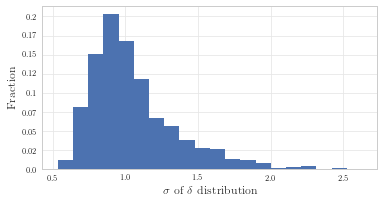

In [67]:
def to_fraction(y, position):
        # Ignore the passed in position. This has the effect of scaling the default
        # tick locations.
        s = str(y/1000.0)[:4]

        # The percent symbol needs escaping in latex
        return s

print len(m),len(sig) 
plt.figure(figsize = (6,3))
plt.hist(sig,bins = 20)
(mu, sigma) = norm.fit(snCheck)
print 'mu',mu
print 'sigma',sigma
print np.std(sig)
print np.mean(sig)
plt.xlabel(r'$\sigma$ of $\delta$ distribution')
formatter = FuncFormatter(to_fraction)
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Fraction')
plt.savefig('../../Thesis/Figures/checking_sTn_Sigma.pdf',bbox_inches='tight')

In [68]:
print 'P-values:'
sig = np.array(sig)

print 'with sigma',sigma_tracingGal,'p-value tracing Gal',len(sig[sig>sigma_tracingGal])/1000.0
print ''
print 'with sigma',sigma_obs0p1_10ng,'p-value 0.1muJy:',len(sig[sig>sigma_obs0p1_10ng])/1000.0
print 'with sigma',sigma_obs2p0_10ng,'p-value 2.0muJy at 10ng:',len(sig[sig>sigma_obs2p0_10ng])/1000.0
print 'with sigma',sigma_obs2p0_100ng,'p-value 2.0muJy at 100ng:',len(sig[sig>sigma_obs2p0_100ng])/1000.0
print 'with sigma',sigma_obs2p0_10ng_cut100,'p-value 2.0muJy at 10ng cut at |RM|>100:',len(sig[sig>sigma_obs2p0_10ng_cut100])/1000.0

P-values:
with sigma 0.950185995546 p-value tracing Gal 0.559

with sigma 0.994267706289 p-value 0.1muJy: 0.49
with sigma 0.959508459264 p-value 2.0muJy at 10ng: 0.541
with sigma 1.26720662091 p-value 2.0muJy at 100ng: 0.2
with sigma 1.60982079893 p-value 2.0muJy at 10ng cut at |RM|>100: 0.071


In [69]:

def separatePosNeg(RM,sourceAngle):
    posInd = np.where( RM >= 0)[0]
    negInd = np.where( RM < 0 )[0]
    print len(posInd),len(negInd)
#     e = sourceAngle[:,:2]
#     g = RM/np.max(np.abs(RM))
    pos = np.c_[sourceAngle[posInd], RM[posInd]]  #Translates slice objects to concatenation along the second axis.
    neg = np.c_[sourceAngle[negInd], RM[negInd]]
    print len(RM),len(pos),len(neg)
    return pos,neg

def RMmap_2(p,n,constant,direction,RMType):  #positive,negative,constant,direction,type
    fig = plt.figure(figsize=(3, 3), dpi=200)
    ax = plt.subplot(111)
    try:
        ax.scatter(p[:,0],p[:,1],s =constant*abs(p[:,2]),c = "royalblue",alpha = 0.5,edgecolors='none')#,label = "Positive RM")
    except:
        pass
    try:
        ax.scatter(n[:,0],n[:,1],s = constant*abs(n[:,2]),c = 'indianred',alpha = 0.5,edgecolors='none')#,label = 'Negative RM')
    except:
        pass
    plt.xlabel("RA (degrees)")
    plt.ylabel("dec (degrees)")
    box = ax.get_position()
    ax.set_position([box.x0*1.2, box.y0*1.07+ box.height * 0.1,box.width, box.width])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    
    gll = plt.scatter([],[], s = constant*0.5, marker='o', color='#555555')
    gl = plt.scatter([],[], s = constant*5, marker='o', color='#555555')
    ga = plt.scatter([],[], s = constant*50, marker='o', color='#555555')

    #legend1 = 
    plt.legend((gll,gl,ga),
       (r'0.5 rad/m$^2$', r'5 rad/m$^2$', r'50 rad/m$^2$'),
       scatterpoints=1,
       bbox_to_anchor=(-0.4, 1),#(0.075, 0.91), 
       loc=3,
#        frameon=True,
       ncol=3,
#        title=r'Normalised Rotation Measure (rad/m$^2$)',                 
       fontsize=8)
    
#     ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.11),fancybox=True, shadow=True, ncol=5)
#     leg = plt.gca().add_artist(legend1)
#     frame = leg.get_frame()
#     frame.set_facecolor('white')
    plt.tight_layout()

    plt.savefig('paper_RMmap_.pdf',bbox_inches='tight')

1382 1293
2675 1382 1293
0.00704372734693 22.5560283252
-44.6354378489 -0.00179363665219


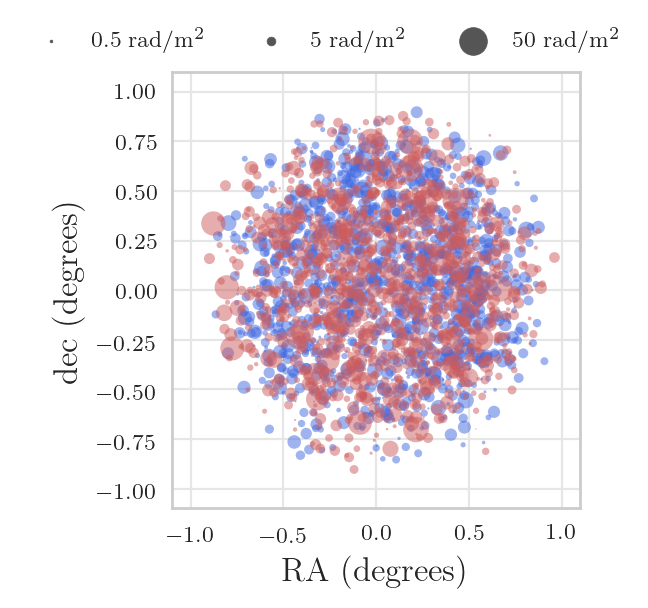

In [70]:
direction = 'REALISTIC_1e-08_0.5_5000'

P,N = separatePosNeg(sourceRM_beforeError+overallRM[direction],anglePos)
print np.min(P[:,2]),np.max(P[:,2])
print np.min(N[:,2]),np.max(N[:,2])
RMmap_2(P,N,2,direction,'')
